In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import verde as vd
import harmonica as hm
import boule as bl
import ensaio
import pygmt
import pyproj

# import utm
import geopandas as gpd

import pathlib
import os

import warnings
warnings.filterwarnings("ignore")

# Load gravity data table

In [2]:
data_dir = pathlib.Path("..") / "data"
image_dir = pathlib.Path("..") / "report" / "figures"
shape_dir = pathlib.Path("..") / "data" / "shapefile"

mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

Read shapefile

In [3]:
pluton = os.path.join(shape_dir/"corrego_seco.shp")

Read regional data

In [4]:
data = pd.read_csv(data_dir/'CSG_with_regional_from_satellite.csv', delimiter=',')

In [5]:
data.head(5)

data.Latitude.min()
data.Latitude.max()
data.Longitude.min()
data.Longitude.max()

-49.9560379748049

In [6]:
region = (-50.172916666667, -49.806250000000, -16.597916666667, -16.222916666667)
region_pad = vd.pad_region(region, pad=-0.125)
# region_pad = vd.pad_region(region, pad=-0.05)

print(region_pad)

(-50.047916666667, -49.93125, -16.472916666667, -16.347916666667)


In [7]:
topography = pygmt.datasets.load_earth_relief(resolution="01s", region=region_pad)
topography = topography.rename({'lon': 'longitude', 'lat': 'latitude'})
topography

<xarray.DataArray 'z' (latitude: 466, longitude: 436)> Size: 2MB
array([[767., 770., 774., ..., 659., 667., 672.],
       [767., 772., 775., ..., 664., 669., 675.],
       [769., 772., 775., ..., 667., 673., 677.],
       ...,
       [751., 750., 750., ..., 778., 780., 782.],
       [747., 746., 747., ..., 777., 780., 782.],
       [744., 744., 745., ..., 775., 779., 781.]])
Coordinates:
  * latitude   (latitude) float64 4kB -16.48 -16.47 -16.47 ... -16.35 -16.35
  * longitude  (longitude) float64 3kB -50.05 -50.05 -50.05 ... -49.93 -49.93
Attributes:
    Conventions:       CF-1.7
    title:             
    history:           gmt grdblend @earth_relief_01s_g/ -R-50.05/-49.9291666...
    description:       IGPP Earth relief
    long_name:         z
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

In [8]:
topography = topography.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
topography_table = vd.grid_to_table(topography)

In [9]:
geoid = pygmt.datasets.load_earth_geoid(resolution="01m", region=region_pad, registration="gridline")
geoid = geoid.rename({'lon': 'longitude', 'lat': 'latitude'})

geoid = geoid.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
interpolator = vd.KNeighbors()

geoid_table = vd.grid_to_table(geoid)
geoid_1 = vd.grid_to_table(topography)


interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.z)
geoid_1 = geoid_1.assign(elevation=interpolator.predict((geoid_1.longitude, geoid_1.latitude)))

geoid_values = np.reshape(geoid_1.elevation, topography.shape)
geoid = xr.DataArray(geoid_values, coords=[topography.latitude, topography.longitude], dims=['latitude', 'longitude'])
geoid

<xarray.DataArray (latitude: 450, longitude: 420)> Size: 2MB
array([[-7.27999973, -7.27999973, -7.27999973, ..., -7.75      ,
        -7.75      , -7.75      ],
       [-7.27999973, -7.27999973, -7.27999973, ..., -7.75      ,
        -7.75      , -7.75      ],
       [-7.27999973, -7.27999973, -7.27999973, ..., -7.75      ,
        -7.75      , -7.75      ],
       ...,
       [-7.21000004, -7.21000004, -7.21000004, ..., -7.5999999 ,
        -7.5999999 , -7.5999999 ],
       [-7.21000004, -7.21000004, -7.21000004, ..., -7.5999999 ,
        -7.5999999 , -7.5999999 ],
       [-7.21000004, -7.21000004, -7.21000004, ..., -7.5999999 ,
        -7.5999999 , -7.5999999 ]])
Coordinates:
  * latitude   (latitude) float64 4kB -16.47 -16.47 -16.47 ... -16.35 -16.35
  * longitude  (longitude) float64 3kB -50.05 -50.05 -50.05 ... -49.93 -49.93

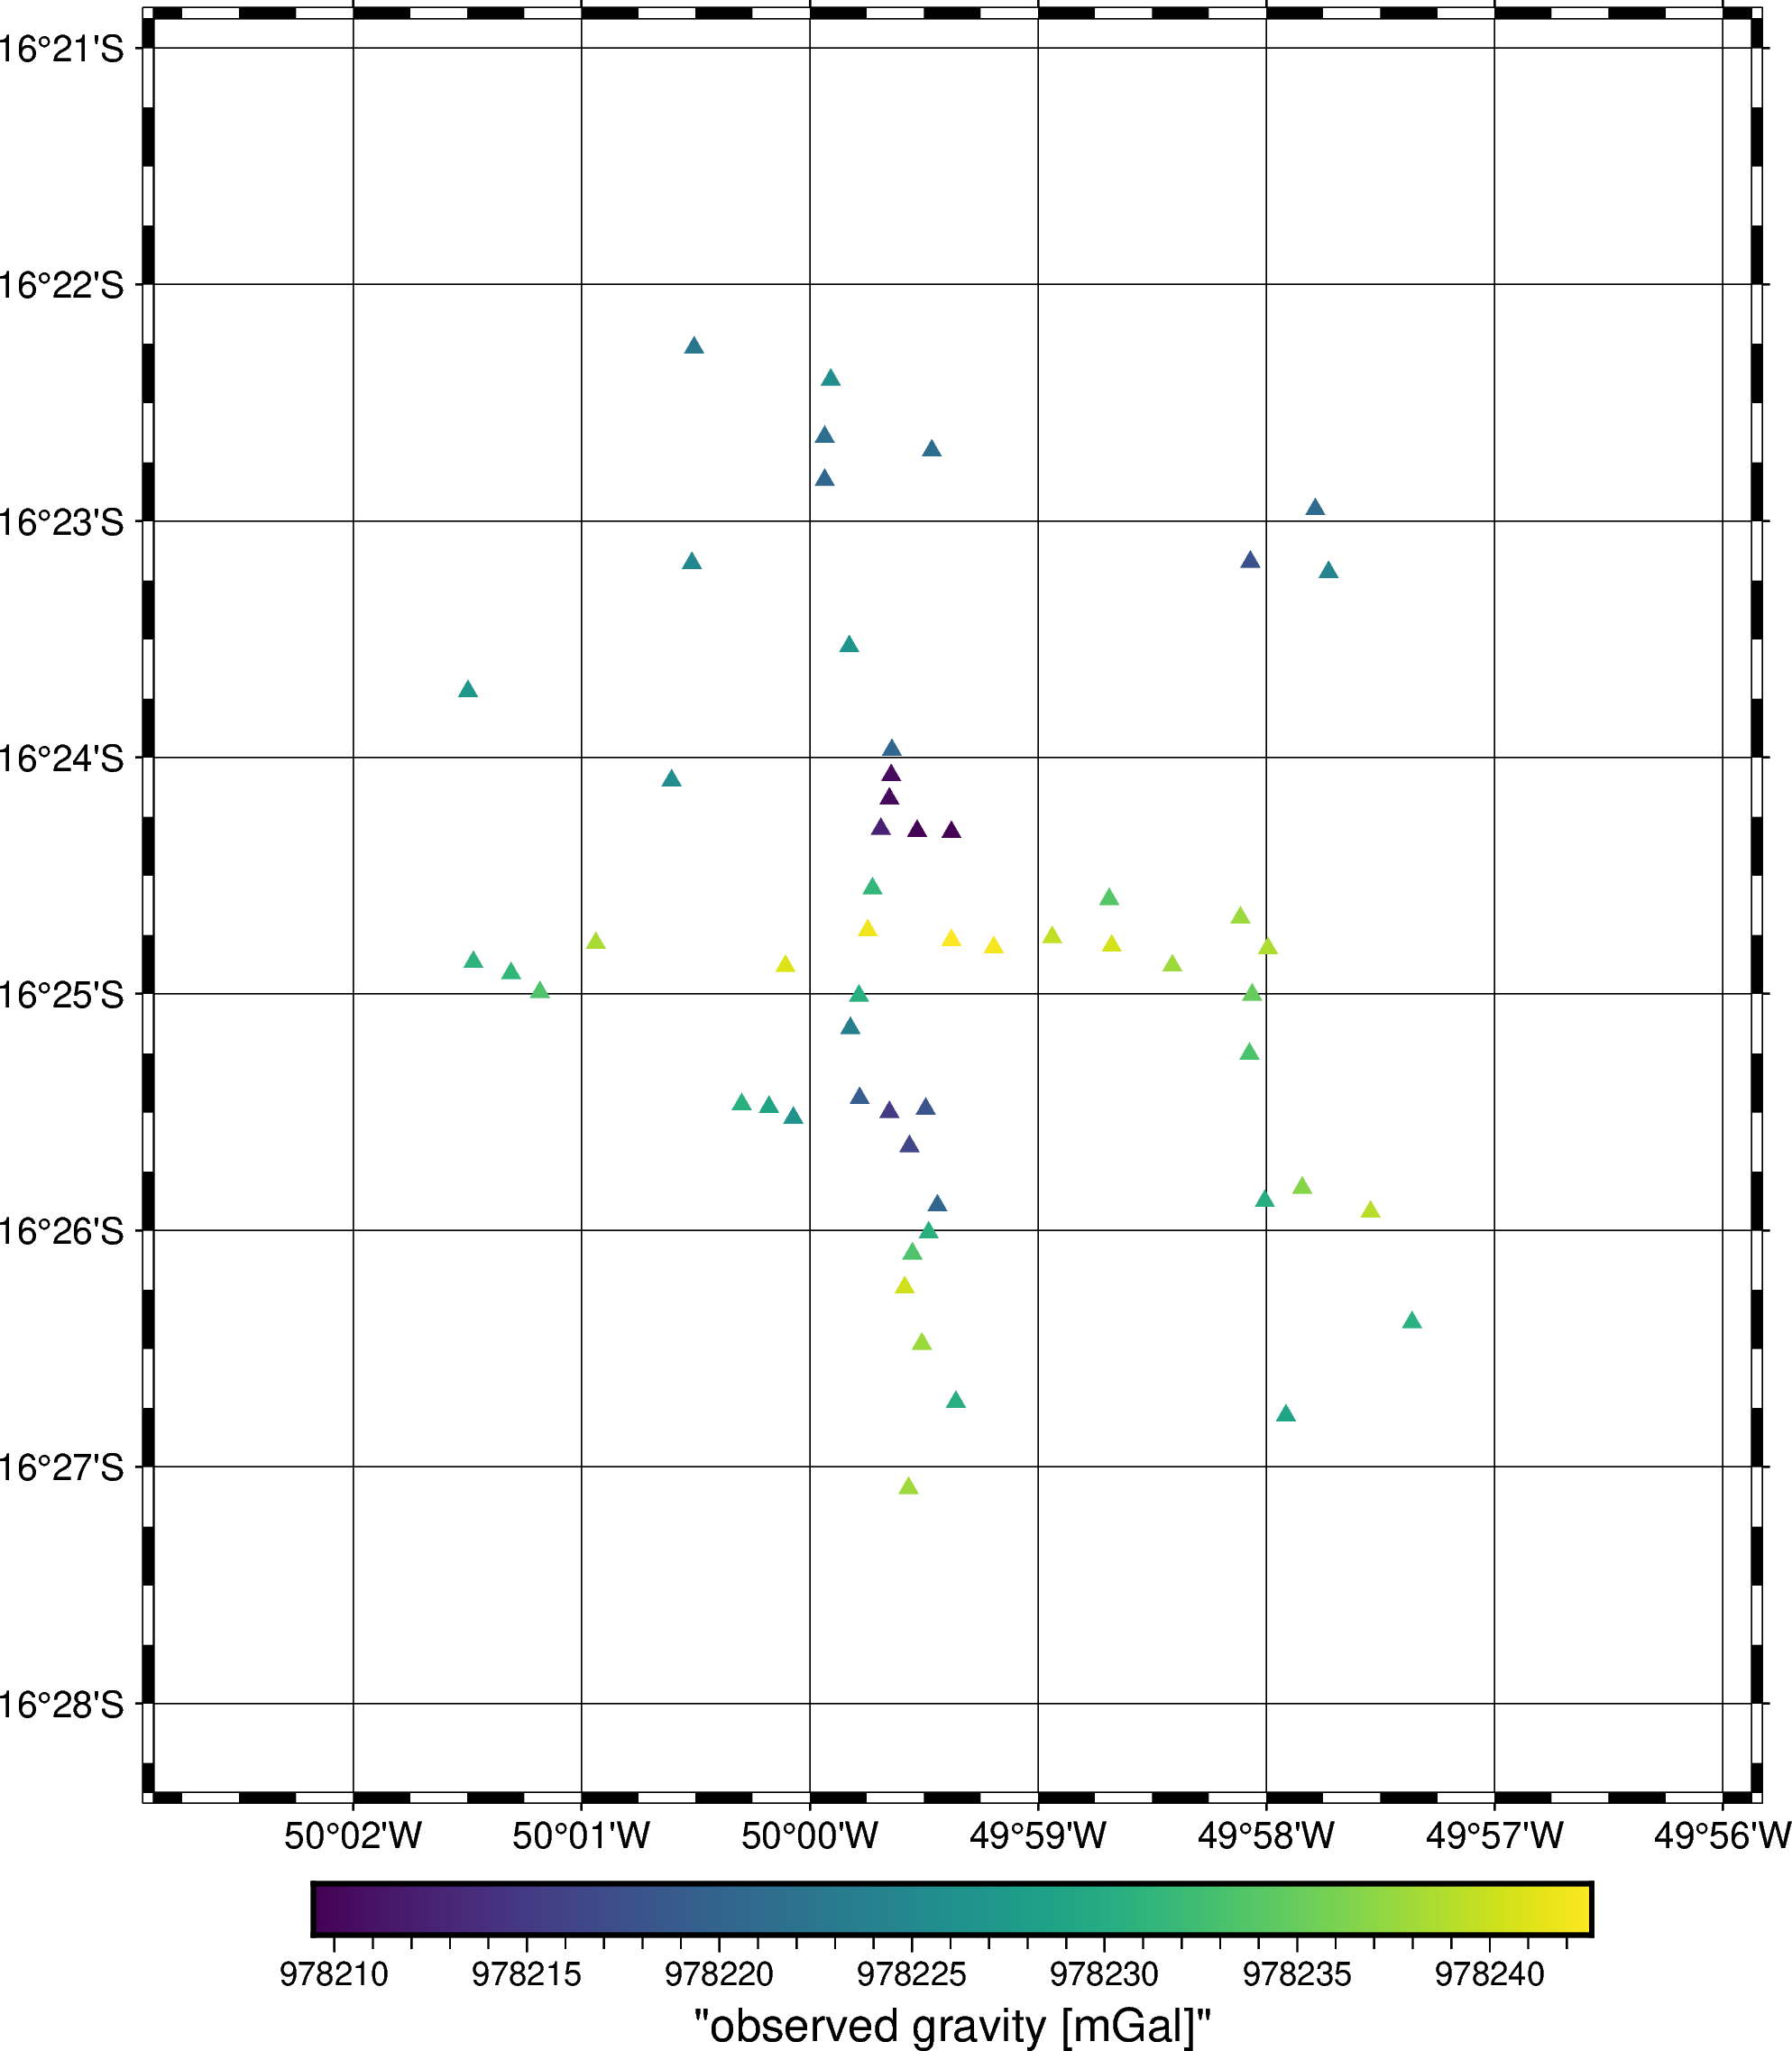

In [10]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="viridis", series=[data.Gravity.min(), data.Gravity.max()])

fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    fill=data.Gravity,
    cmap=True,
    style="t6p",
    projection="M15c",
    frame="afg",
)
fig.colorbar(frame='af+l"observed gravity [mGal]"')

fig.show(width=600)

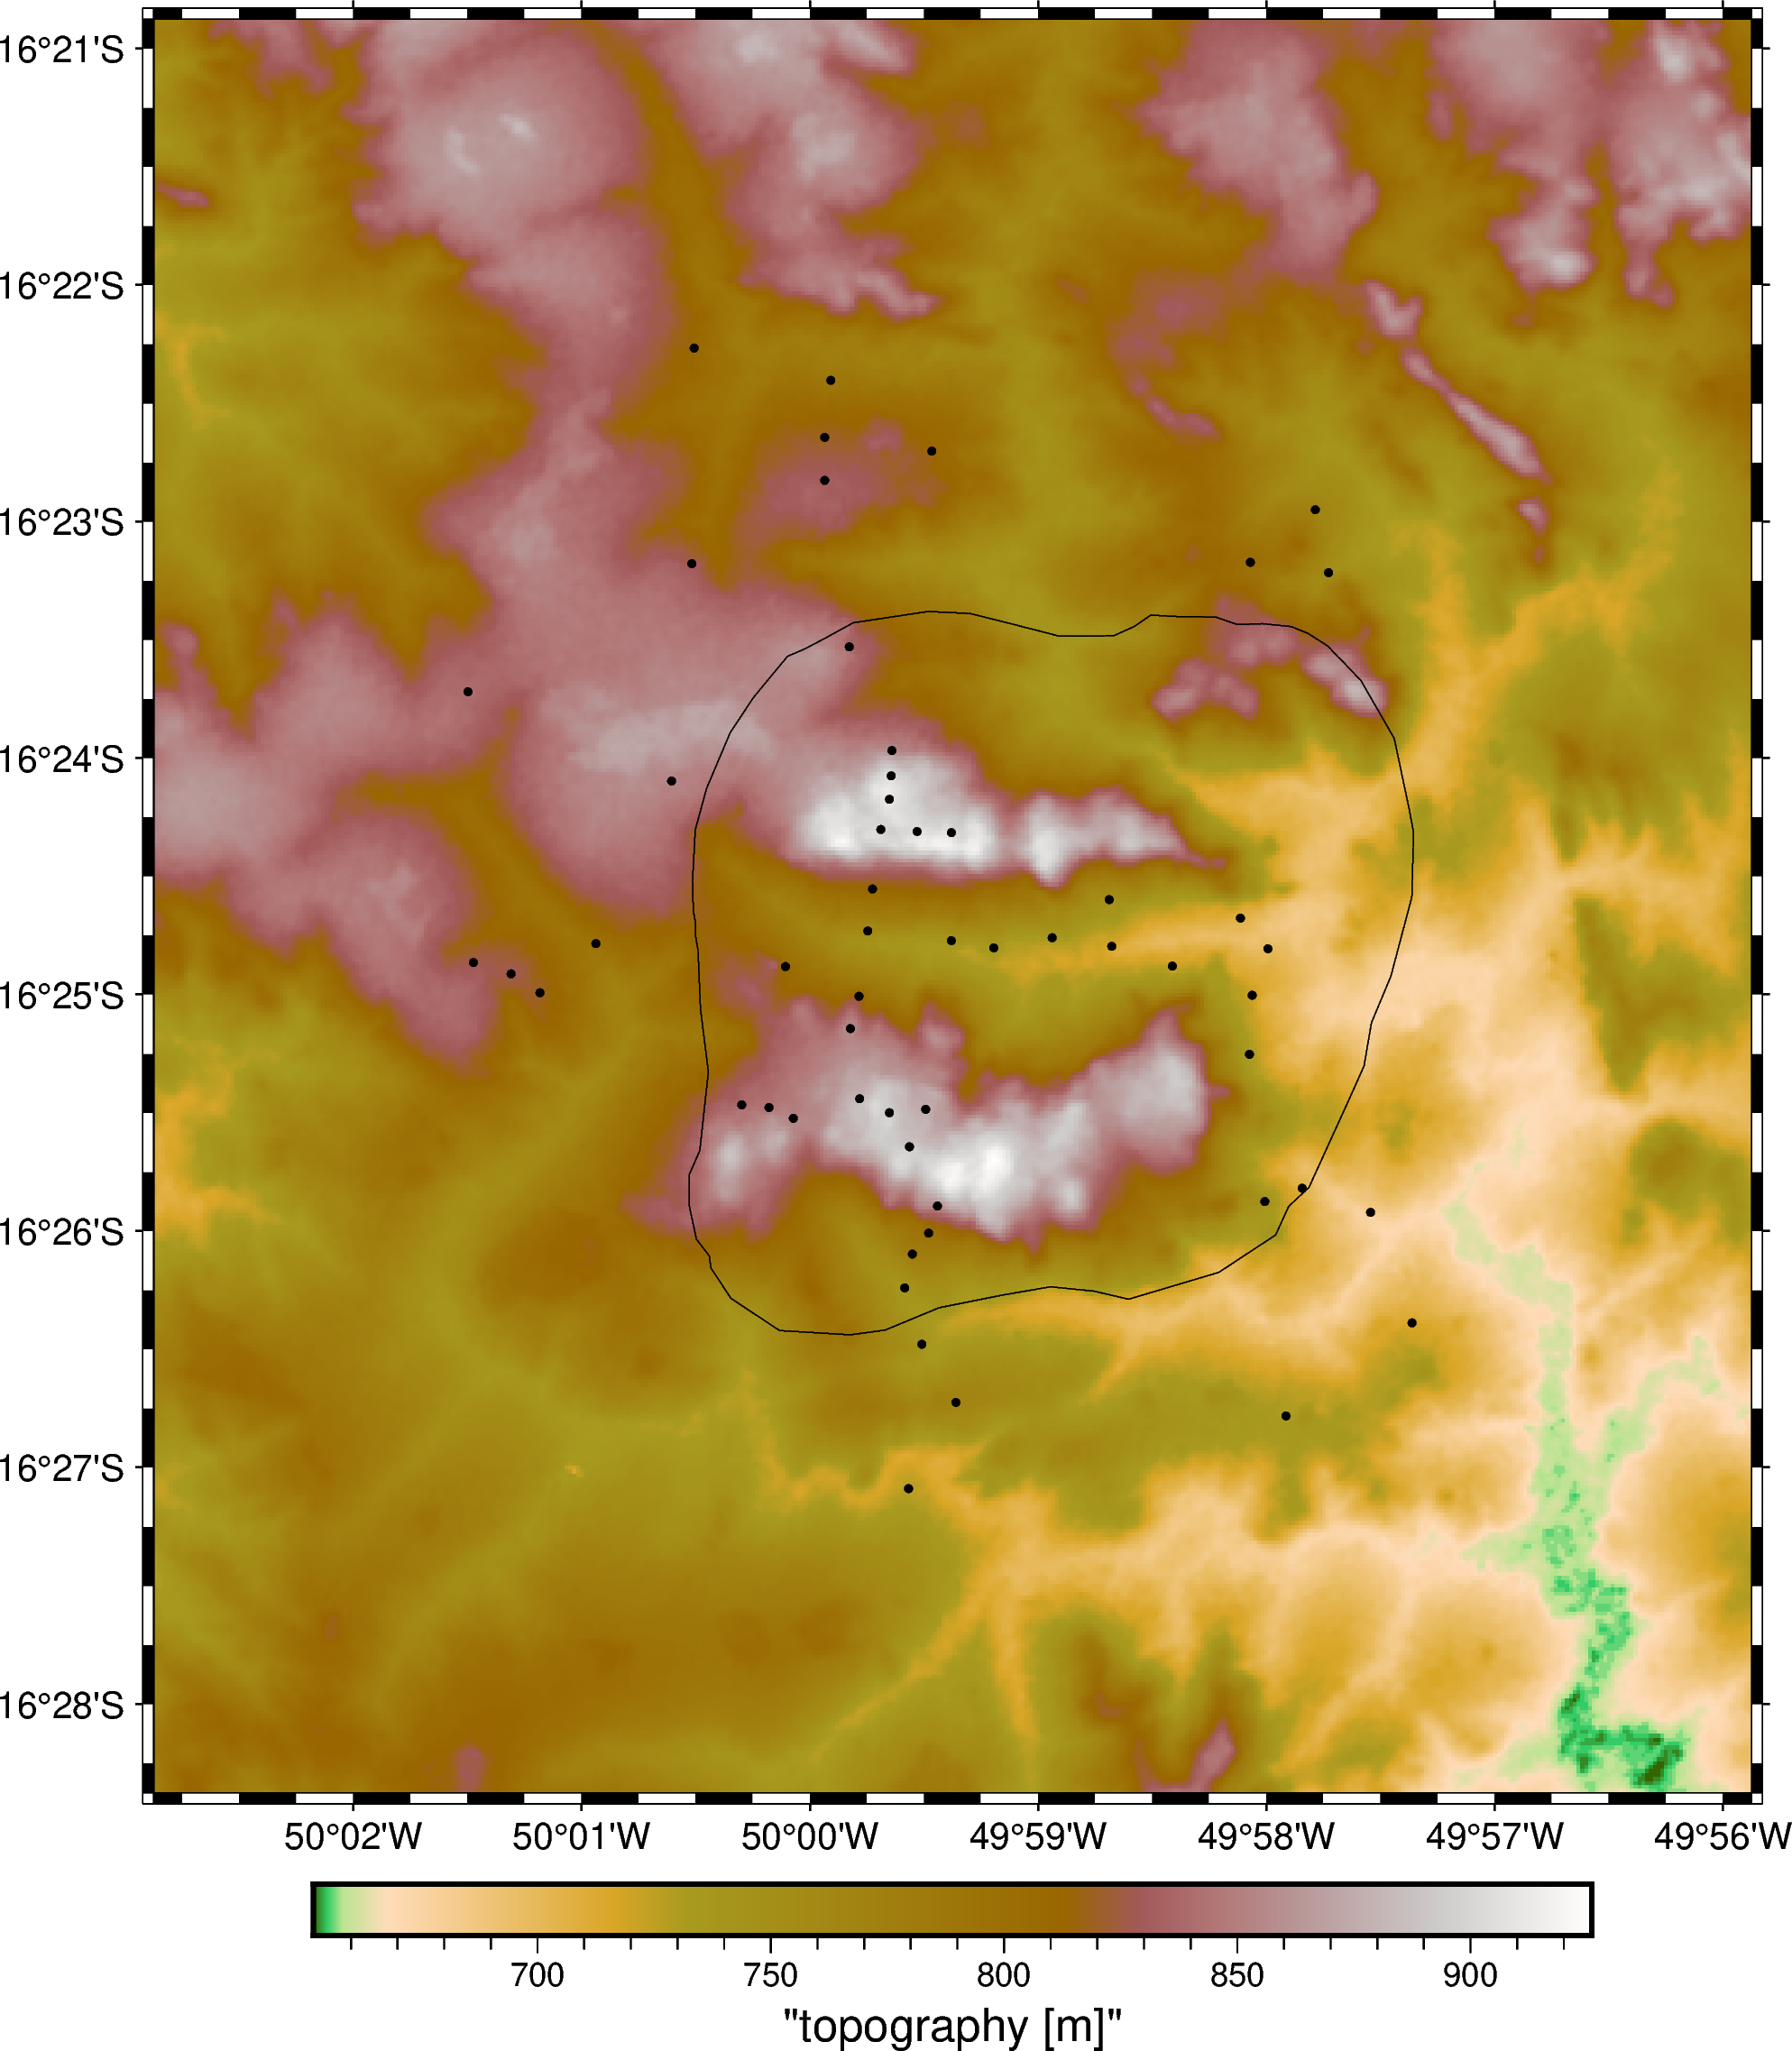

In [11]:
fig = pygmt.Figure()
fig.grdimage(topography, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"topography [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.08c",
    fill="black",
)
fig.plot(data=pluton, projection='M')
fig.show(width=600)

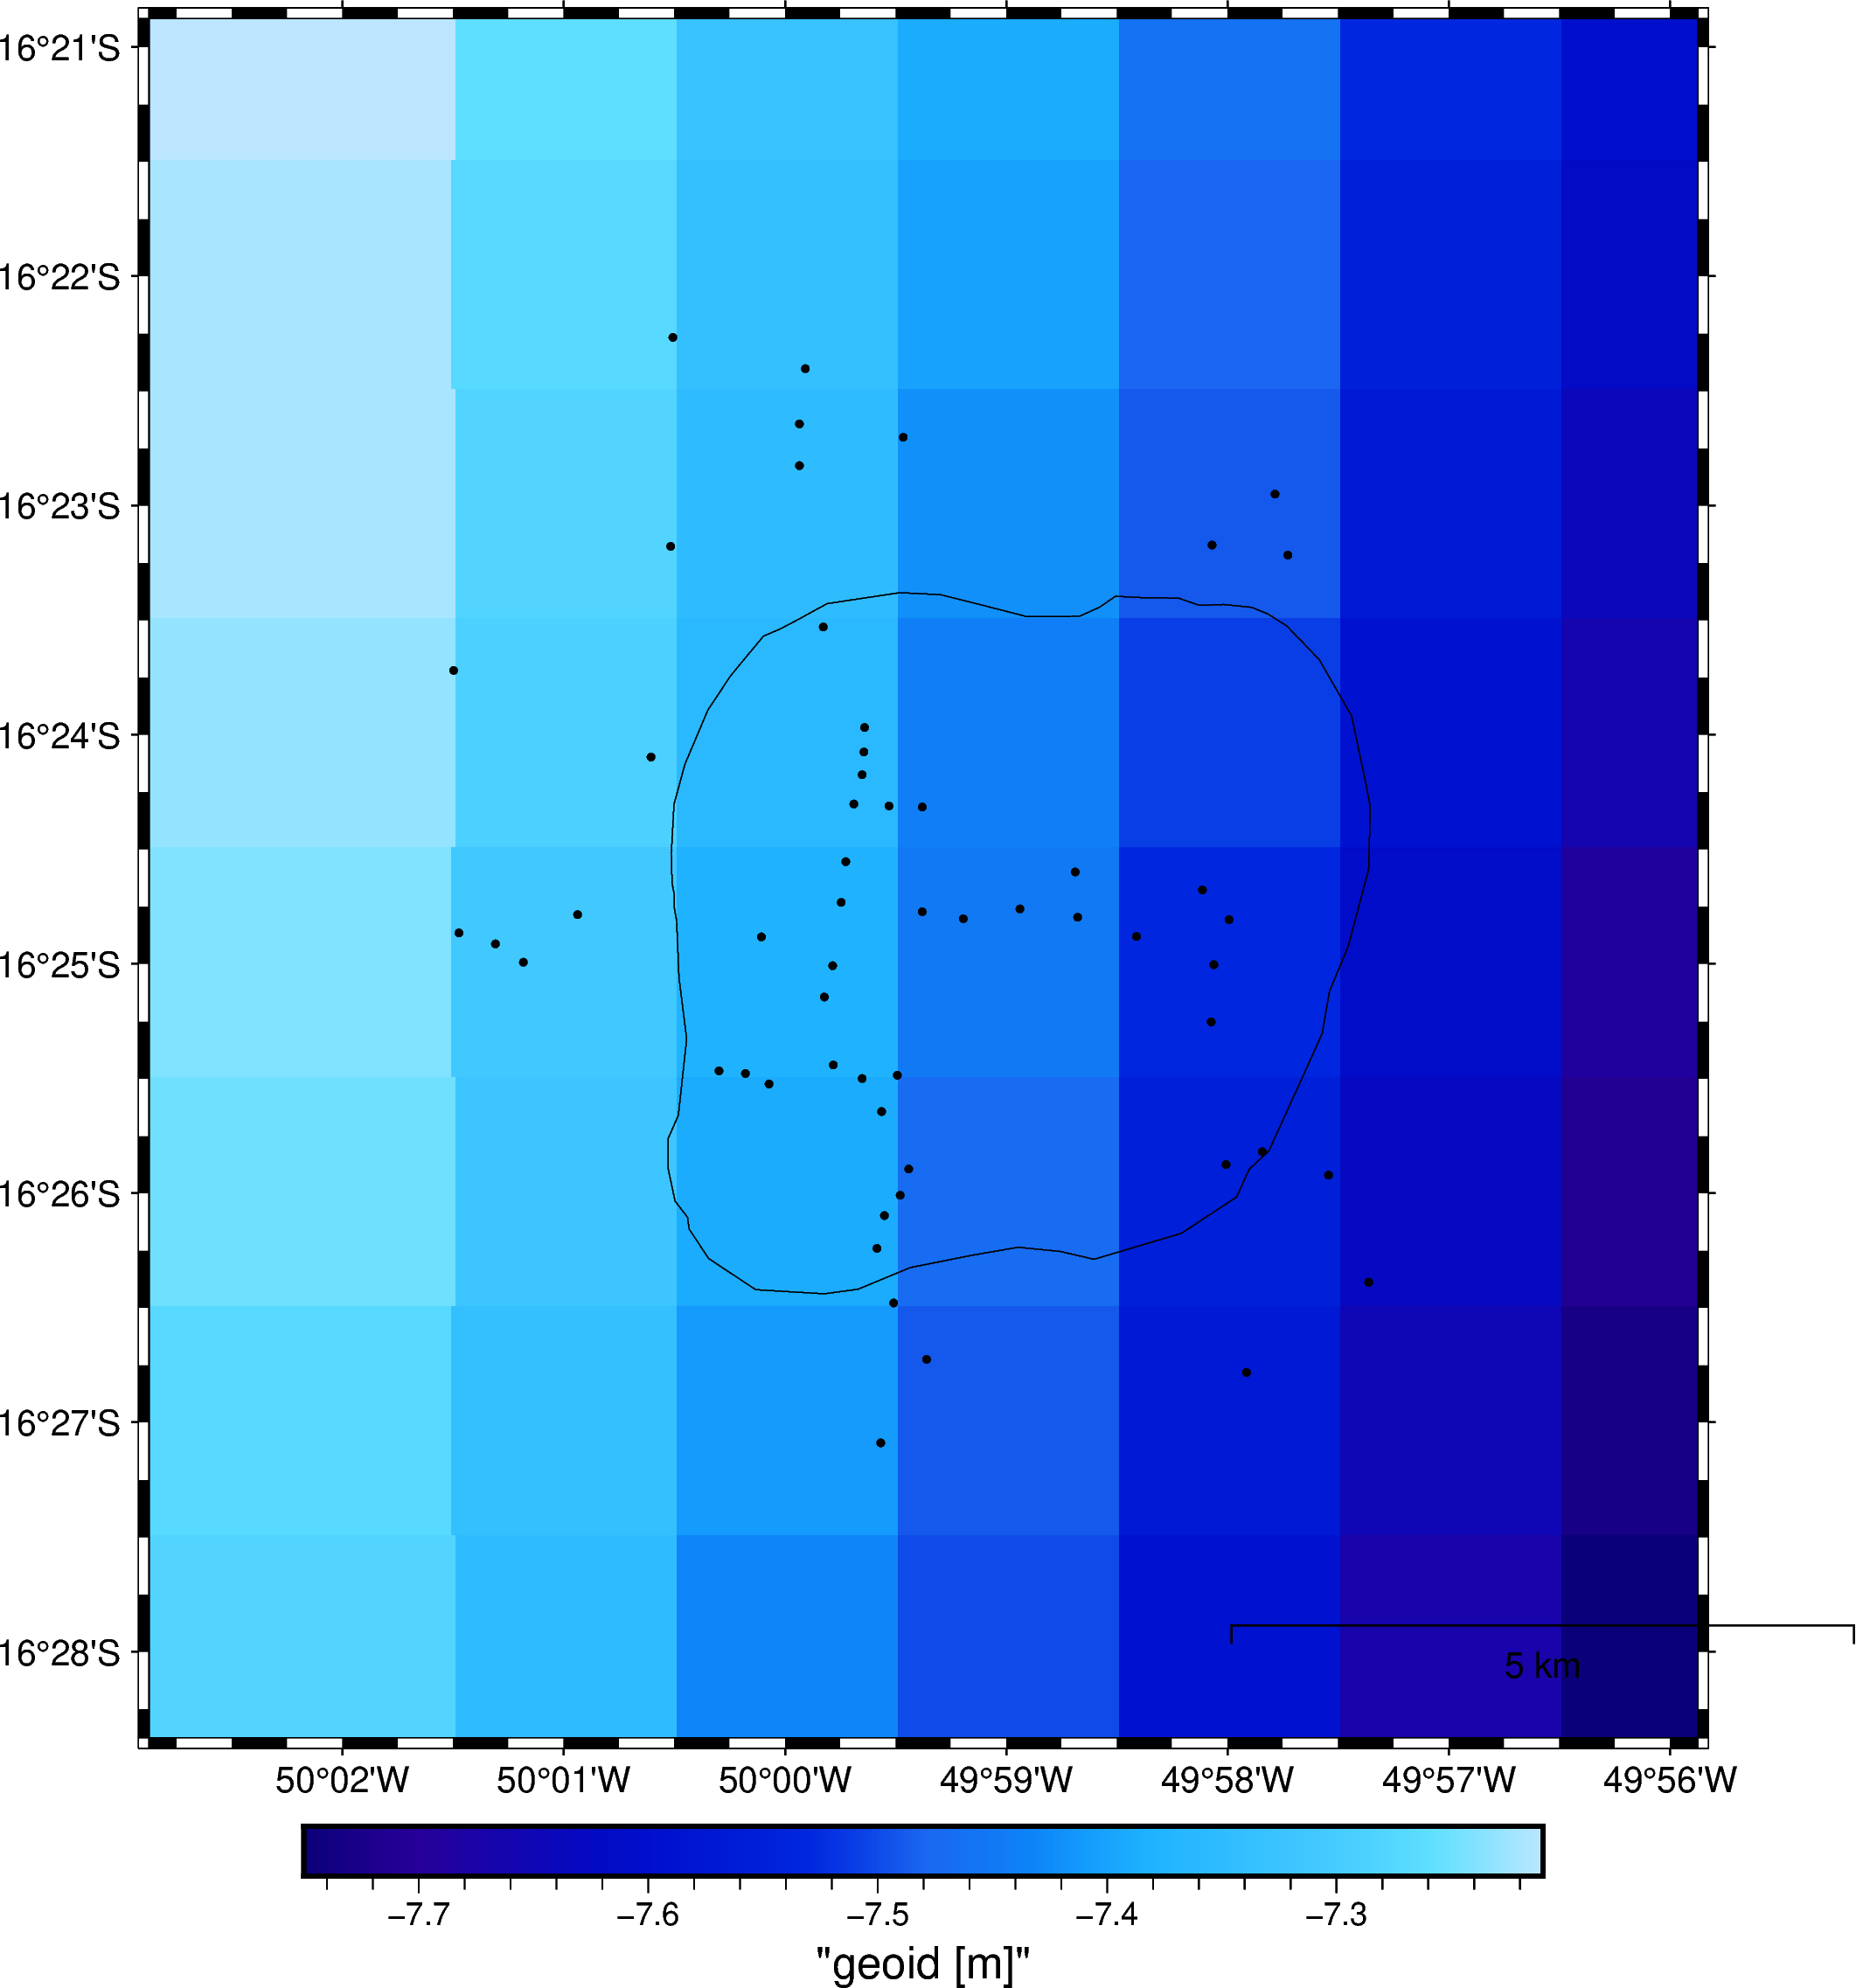

In [12]:
fig = pygmt.Figure()
fig.grdimage(geoid, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"geoid [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.08c",
    fill="black",
)
fig.plot(data=pluton, projection='M')
fig.basemap(map_scale="n0.9/0.06+w5k+u")
fig.show(width=600)

## Converte altitudes ortométricas para geométricas

In [13]:
topography_geometric = topography + geoid
topography_geometric

<xarray.DataArray (latitude: 450, longitude: 420)> Size: 2MB
array([[772.72000027, 774.72000027, 778.72000027, ..., 664.25      ,
        668.25      , 669.25      ],
       [769.72000027, 773.72000027, 778.72000027, ..., 667.25      ,
        669.25      , 671.25      ],
       [769.72000027, 773.72000027, 778.72000027, ..., 668.25      ,
        670.25      , 671.25      ],
       ...,
       [768.78999996, 768.78999996, 768.78999996, ..., 784.4000001 ,
        781.4000001 , 778.4000001 ],
       [766.78999996, 767.78999996, 766.78999996, ..., 782.4000001 ,
        782.4000001 , 781.4000001 ],
       [764.78999996, 764.78999996, 762.78999996, ..., 782.4000001 ,
        780.4000001 , 779.4000001 ]])
Coordinates:
  * latitude   (latitude) float64 4kB -16.47 -16.47 -16.47 ... -16.35 -16.35
  * longitude  (longitude) float64 3kB -50.05 -50.05 -50.05 ... -49.93 -49.93

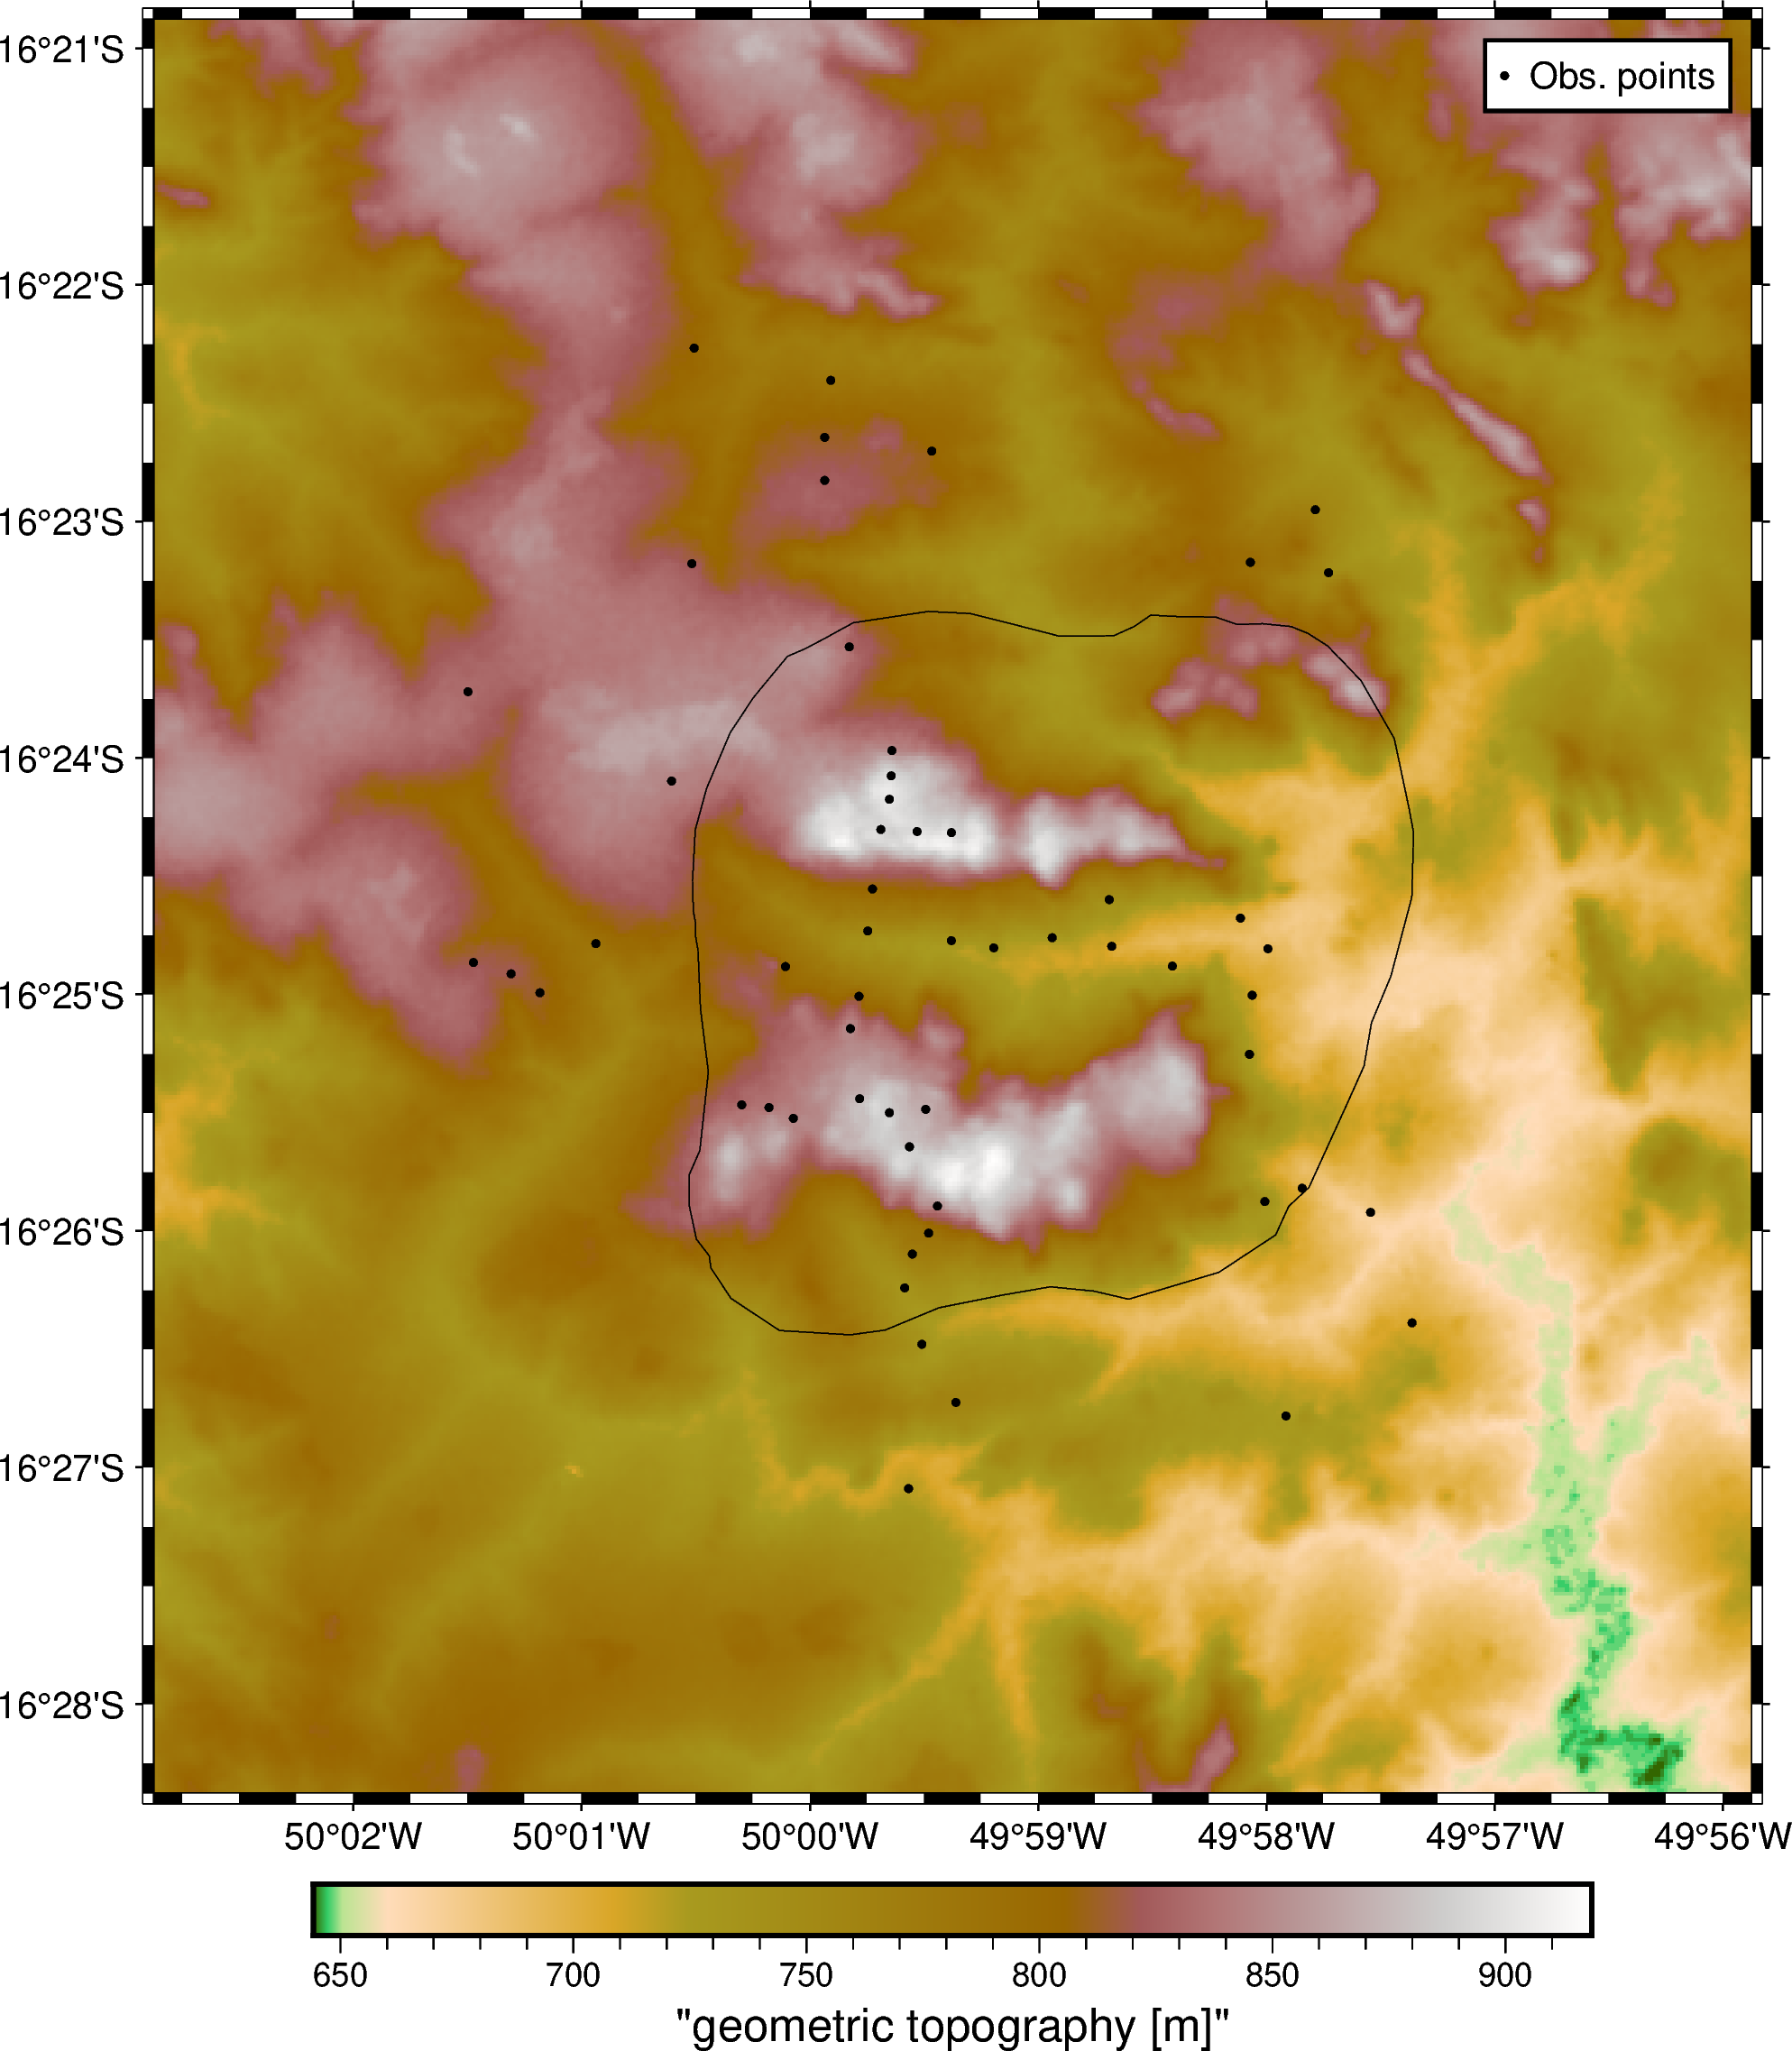

In [14]:
fig = pygmt.Figure()
fig.grdimage(topography_geometric, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"geometric topography [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.08c",
    fill="black",
    label='Obs. points'
)
fig.legend()
fig.plot(data=pluton, projection='M')
fig.show(width=600)

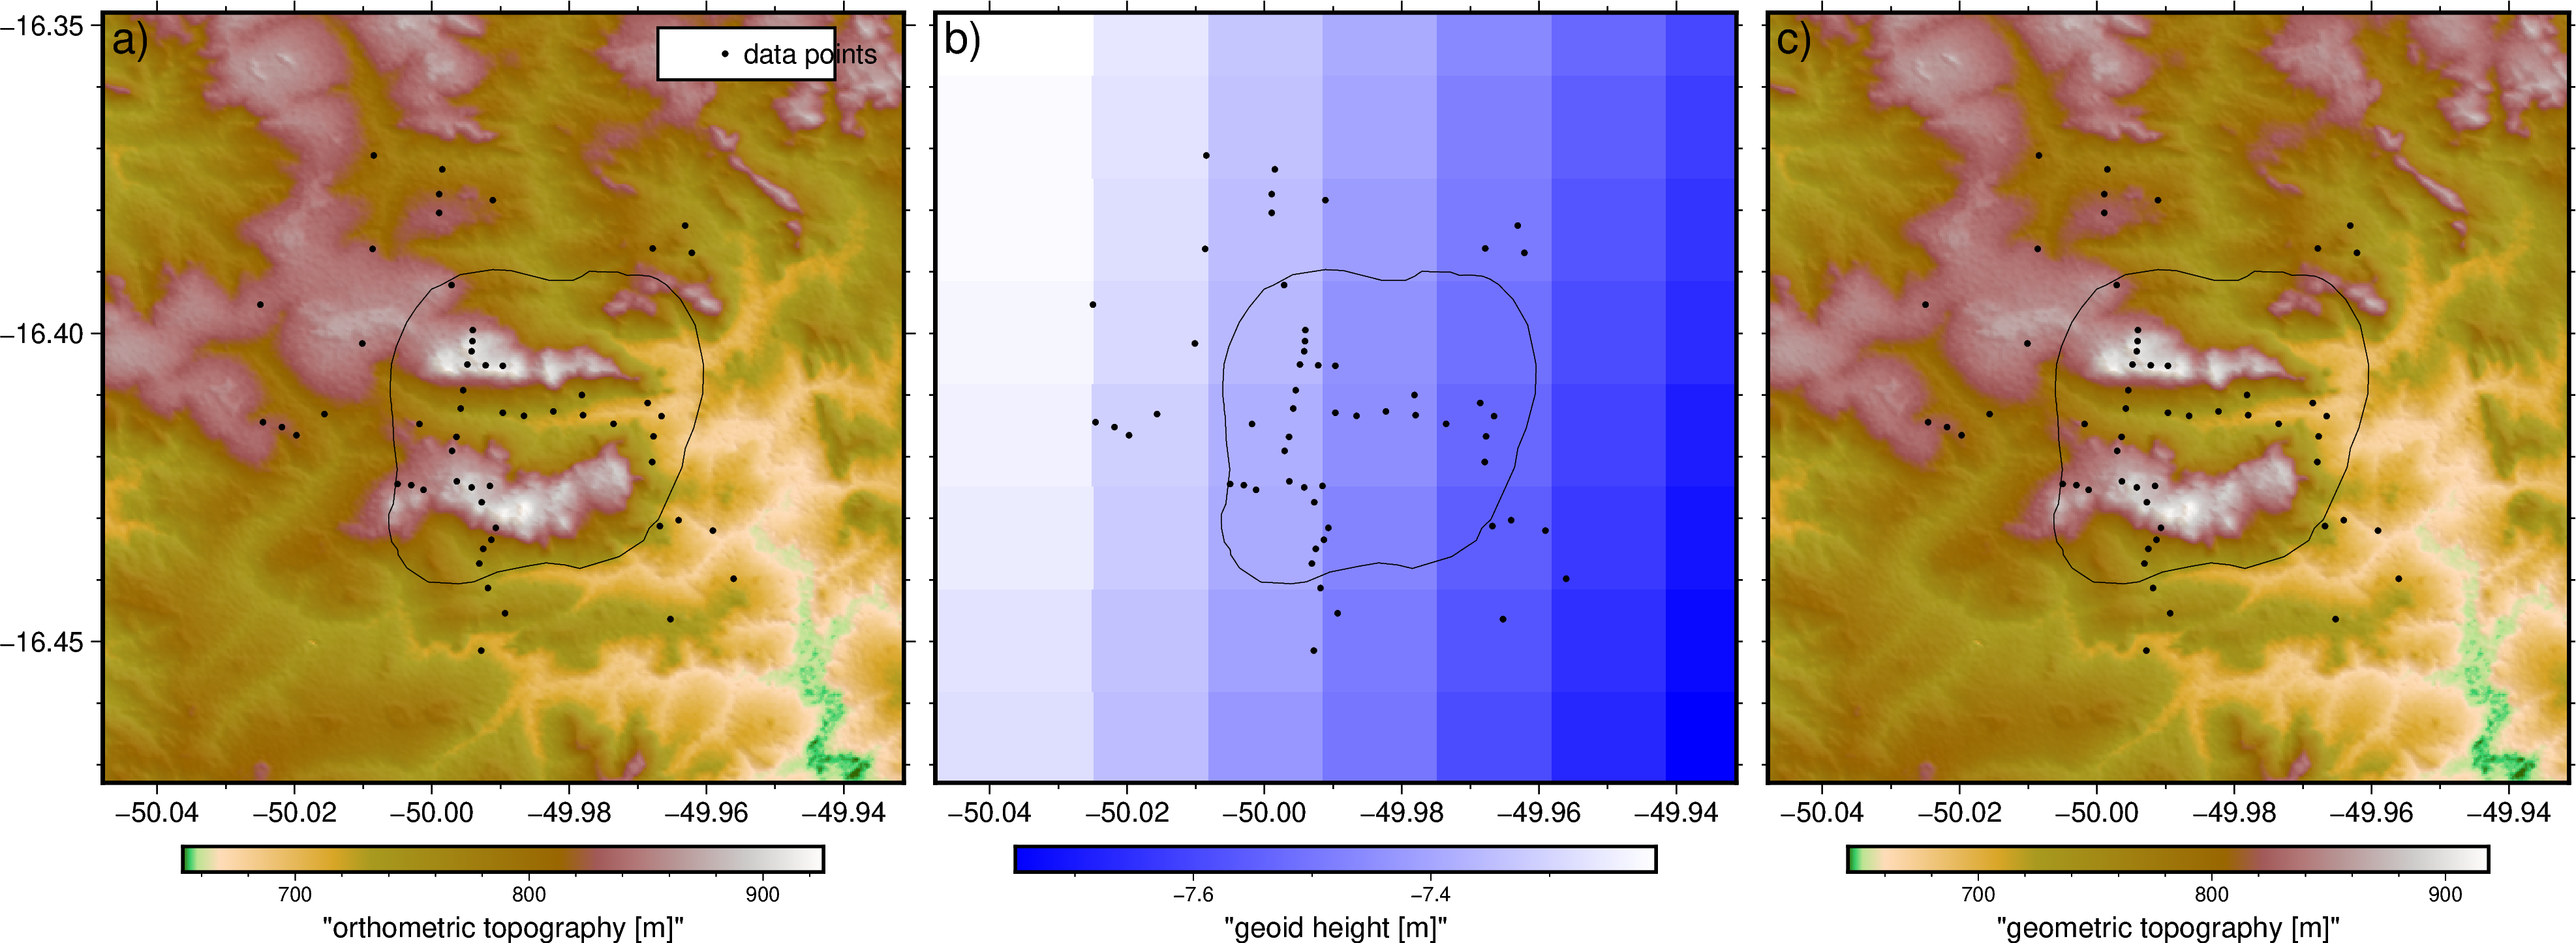

In [15]:
with plt.rc_context(mpl_rc):
    fig = pygmt.Figure()
    # pygmt.config(FORMAT_GEO_MAP="ddd.xx")
    with fig.subplot(
        nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.05c"
    ):
        with fig.set_panel(panel=0):
            
            fig.grdimage(topography, projection="X", cmap="etopo1", frame=["WSne", "xaf", "yaf"],
                        shading="+a45+nt0.15")# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
            fig.colorbar(frame='af+l"orthometric topography [m]"')
            fig.plot(
                        x=data.Longitude,
                        y=data.Latitude,
                        style="c0.08c",
                        fill="black",
                        label='data points'
                    )
            fig.plot(data=pluton, projection='M')
            fig.legend()
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
    
        with fig.set_panel(panel=1):
            fig.grdimage(geoid, projection="X", cmap="polar+h", frame=["WSne", "xaf", "f"])
            fig.colorbar(frame='af+l"geoid height [m]"')
            fig.plot(
                        x=data.Longitude,
                        y=data.Latitude,
                        style="c0.08c",
                        fill="black",
                    )
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
        with fig.set_panel(panel=2):
            fig.grdimage(topography_geometric, projection="X", cmap="etopo1", frame=["WSne", "xaf", "f"],
                        shading="+a45+nt0.15")
            fig.colorbar(frame='af+l"geometric topography [m]"')
            fig.plot(
                        x=data.Longitude,
                        y=data.Latitude,
                        style="c0.08c",
                        fill="black",
                    )
            fig.plot(data=pluton, projection='M')

fig.savefig(image_dir / 'heights.png', dpi=300)
fig.show()


In [16]:
geoid_table = vd.grid_to_table(geoid)
interpolator = vd.KNeighbors()
interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.scalars)
data = data.assign(geoid_m=interpolator.predict((data.Longitude, data.Latitude)))
data = data.assign(height_geometric_m=data.Elevation + data.geoid_m)

## Distúrbio da gravidade

In [17]:
data = data.assign(
    normal_gravity_mgal=bl.WGS84.normal_gravity(data.Latitude, data.height_geometric_m)
)
data = data.assign(gravity_disturbance_mgal=data.Gravity - data.normal_gravity_mgal)
data.head()



,Latitude,Longitude,Gravity,Elevation,Station,regional_bouguer,geoid_m,height_geometric_m,normal_gravity_mgal,gravity_disturbance_mgal
0,-16.386936,-49.962121,978224.514612,749.009,csg10_001,-69.416464,-7.49,741.519,978214.723451,9.791162
1,-16.386212,-49.967838,978217.706954,796.077,csg10_002,-68.666818,-7.49,788.587,978200.161347,17.545607
2,-16.382504,-49.963106,978220.923469,764.537,csg10_003,-69.304928,-7.49,757.047,978209.714654,11.208815
3,-16.431268,-49.966788,978230.218997,734.446,csg10_005,-70.231900,-7.55,726.896,978221.403479,8.815518
4,-16.430324,-49.964049,978236.632548,694.596,csg10_006,-70.673593,-7.55,687.046,978233.656649,2.975899


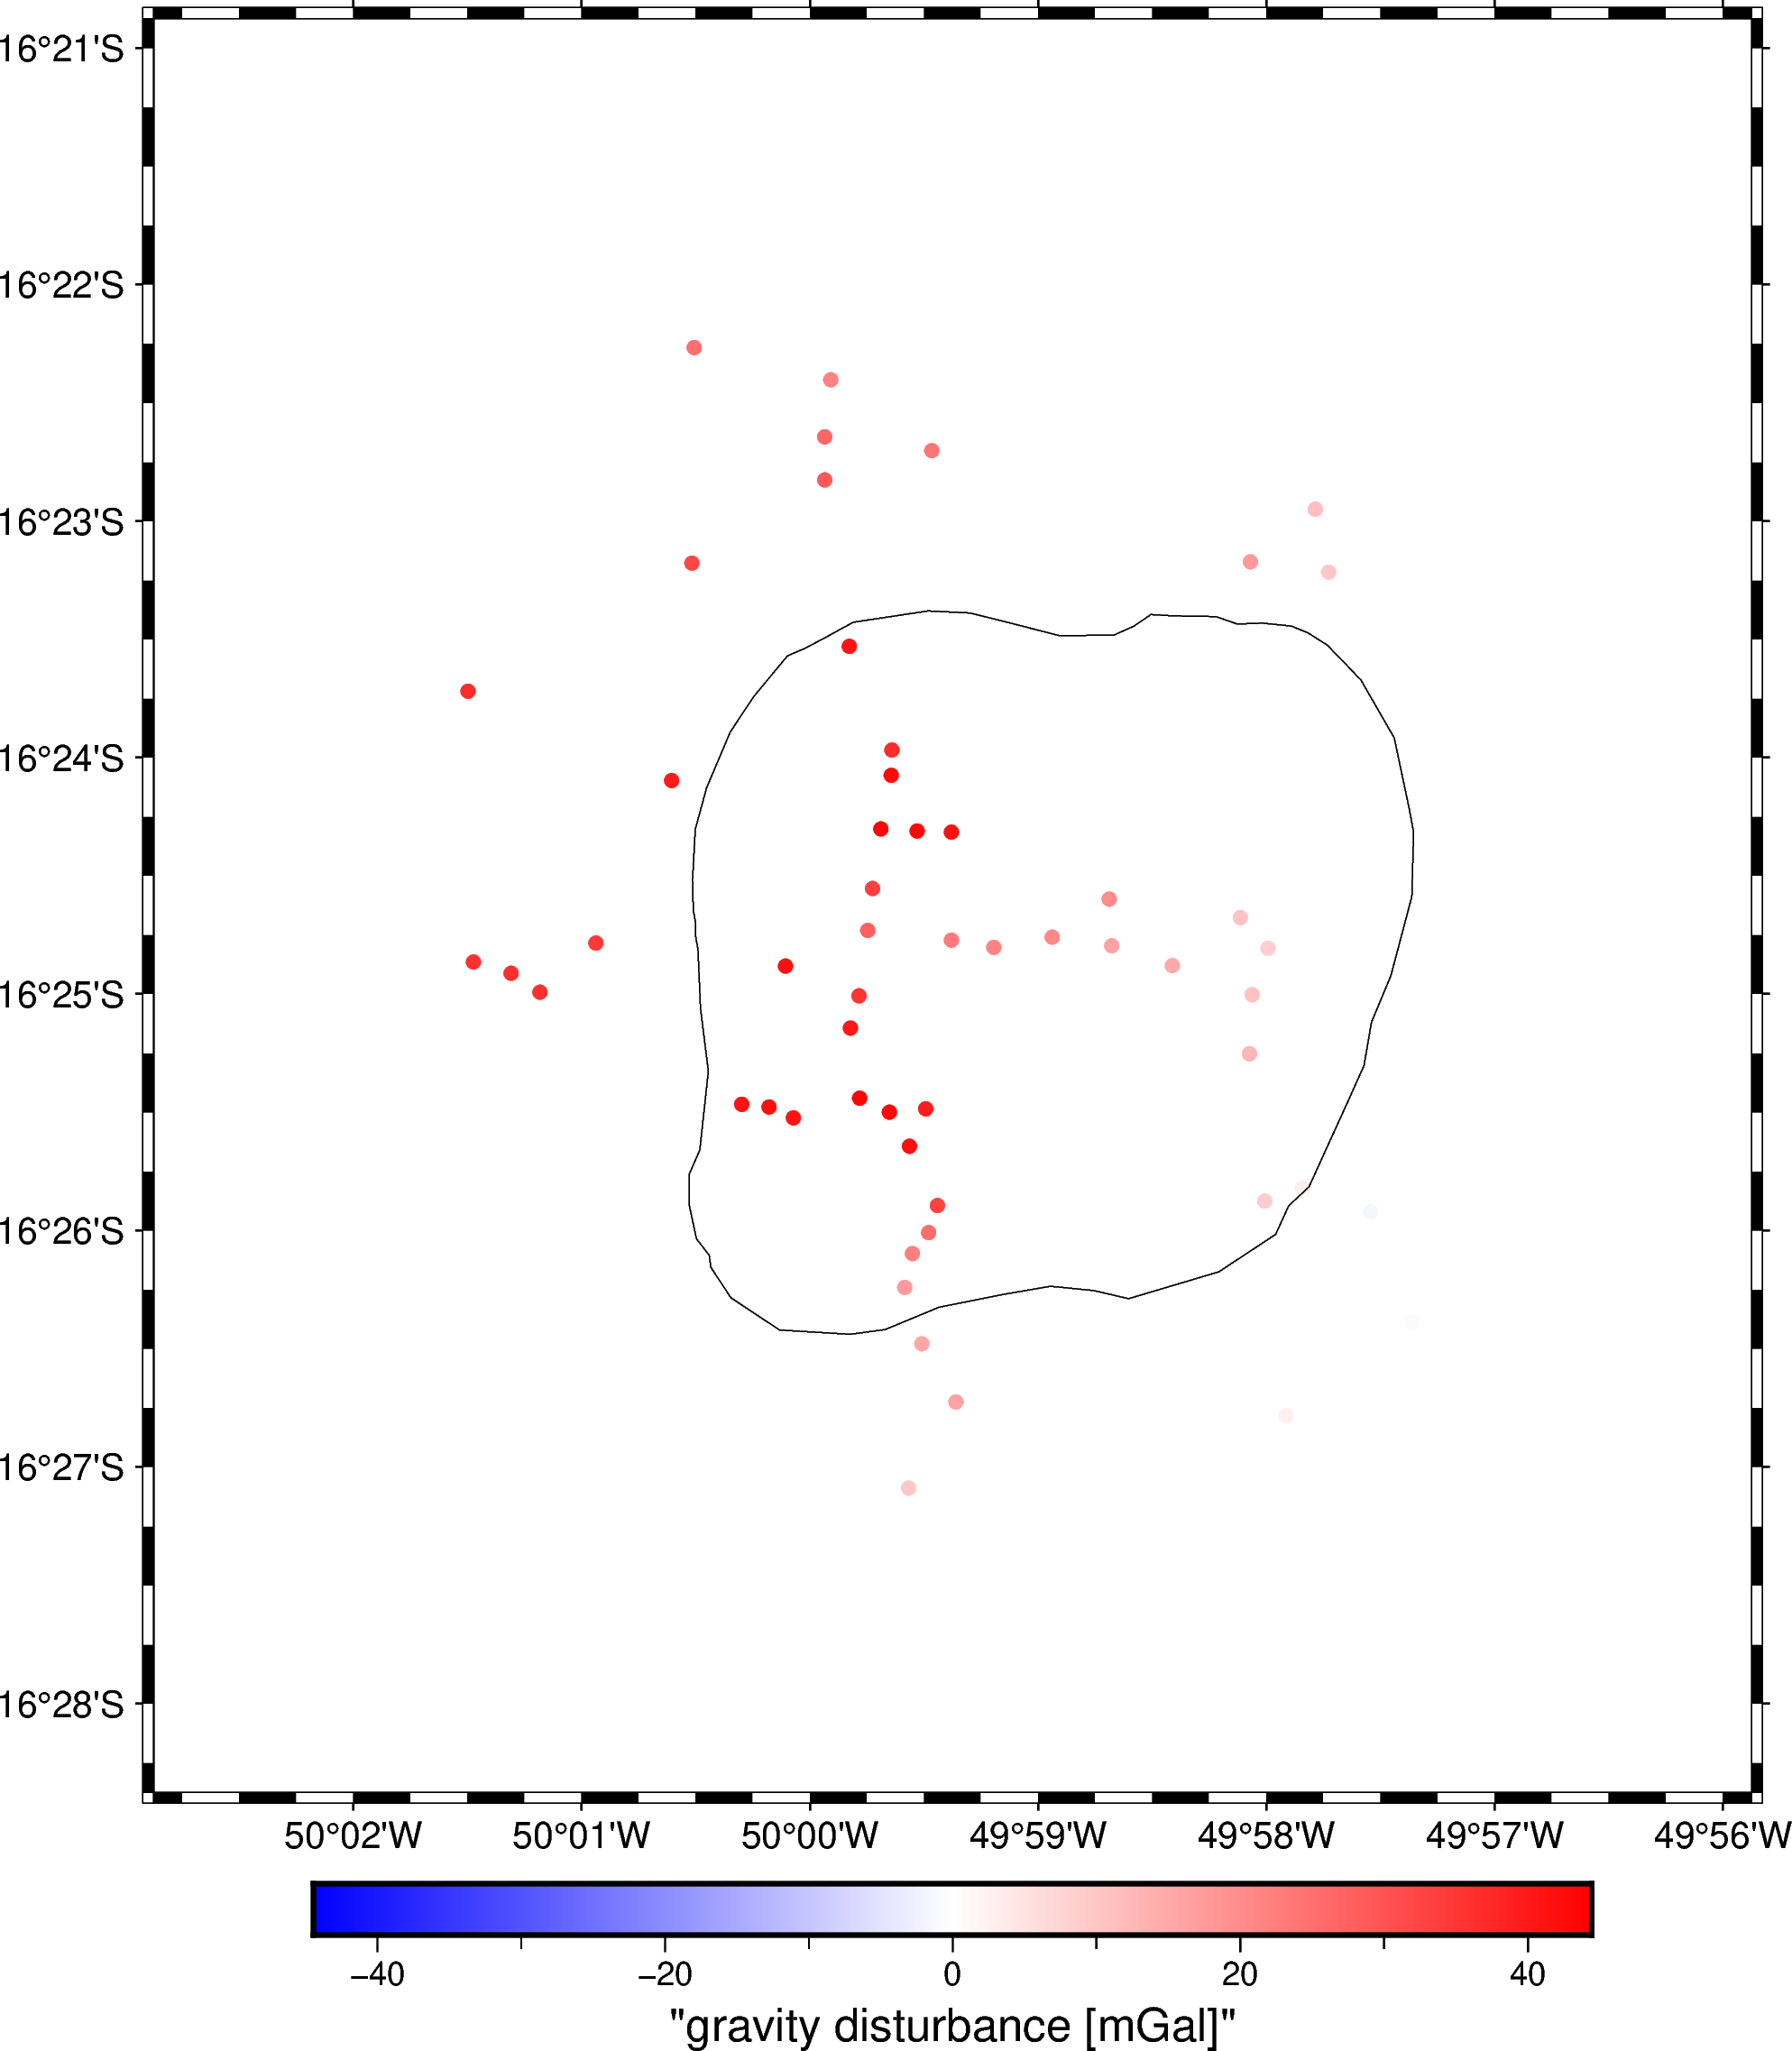

In [18]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_disturbance_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    fill=data.gravity_disturbance_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame="af",
)
fig.plot(data=pluton, projection='M')
fig.colorbar(frame='af+l"gravity disturbance [mGal]"')
fig.show(width=600)

image

<!-- ## Correção topográfica -->

<!-- ![](https://www.fatiando.org/tutorials/_images/topographic-correction.svg) -->

In [19]:
# projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
projection = pyproj.Proj(proj='utm', ellps='WGS84', zone=22, south=True)

In [20]:
easting, northing = projection(data.Longitude.values, data.Latitude.values)
data = data.assign(easting_m=easting, northing_m=northing)
data.head(5)

,Latitude,Longitude,Gravity,Elevation,Station,regional_bouguer,geoid_m,height_geometric_m,normal_gravity_mgal,gravity_disturbance_mgal,easting_m,northing_m
0,-16.386936,-49.962121,978224.514612,749.009,csg10_001,-69.416464,-7.49,741.519,978214.723451,9.791162,610833.211,8.187980e+06
1,-16.386212,-49.967838,978217.706954,796.077,csg10_002,-68.666818,-7.49,788.587,978200.161347,17.545607,610223.040,8.188063e+06
2,-16.382504,-49.963106,978220.923469,764.537,csg10_003,-69.304928,-7.49,757.047,978209.714654,11.208815,610730.539,8.188471e+06
3,-16.431268,-49.966788,978230.218997,734.446,csg10_005,-70.231900,-7.55,726.896,978221.403479,8.815518,610309.782,8.183078e+06
4,-16.430324,-49.964049,978236.632548,694.596,csg10_006,-70.673593,-7.55,687.046,978233.656649,2.975899,610602.829,8.183181e+06


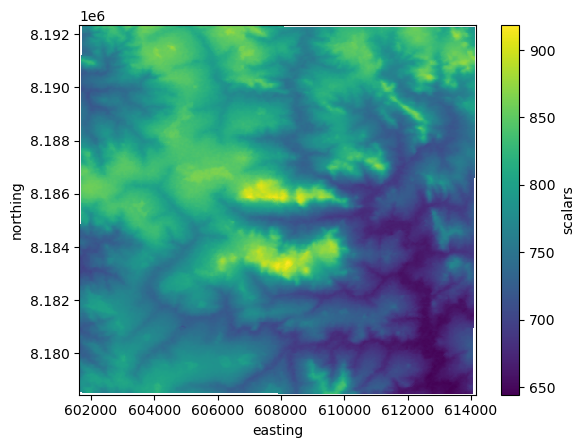

In [21]:
topography_proj = vd.project_grid(topography_geometric, projection, method="nearest")
topography_proj.plot()

In [22]:
# topography_density = np.where(topography_proj > 0, 2670, 1040 - 2670)
topography_density = np.where(topography_proj > 0, 2710, 1040 - 2670)
topography_model = hm.prism_layer(
    coordinates=(topography_proj.easting, topography_proj.northing),
    surface=topography_proj,
    reference=0,
    properties={"density": topography_density}
)

In [23]:
# topography_model.density.plot()

In [24]:
coordinates = (data.easting_m, data.northing_m, data.height_geometric_m)
terrain_effect = topography_model.prism_layer.gravity(coordinates, field="g_z")

In [25]:
data = data.assign(
    gravity_bouguer_mgal=data.gravity_disturbance_mgal - terrain_effect
)
data.head()

,Latitude,Longitude,Gravity,Elevation,Station,regional_bouguer,geoid_m,height_geometric_m,normal_gravity_mgal,gravity_disturbance_mgal,easting_m,northing_m,gravity_bouguer_mgal
0,-16.386936,-49.962121,978224.514612,749.009,csg10_001,-69.416464,-7.49,741.519,978214.723451,9.791162,610833.211,8.187980e+06,-67.401222
1,-16.386212,-49.967838,978217.706954,796.077,csg10_002,-68.666818,-7.49,788.587,978200.161347,17.545607,610223.040,8.188063e+06,-65.394012
2,-16.382504,-49.963106,978220.923469,764.537,csg10_003,-69.304928,-7.49,757.047,978209.714654,11.208815,610730.539,8.188471e+06,-68.026055
3,-16.431268,-49.966788,978230.218997,734.446,csg10_005,-70.231900,-7.55,726.896,978221.403479,8.815518,610309.782,8.183078e+06,-67.501382
4,-16.430324,-49.964049,978236.632548,694.596,csg10_006,-70.673593,-7.55,687.046,978233.656649,2.975899,610602.829,8.183181e+06,-68.858840


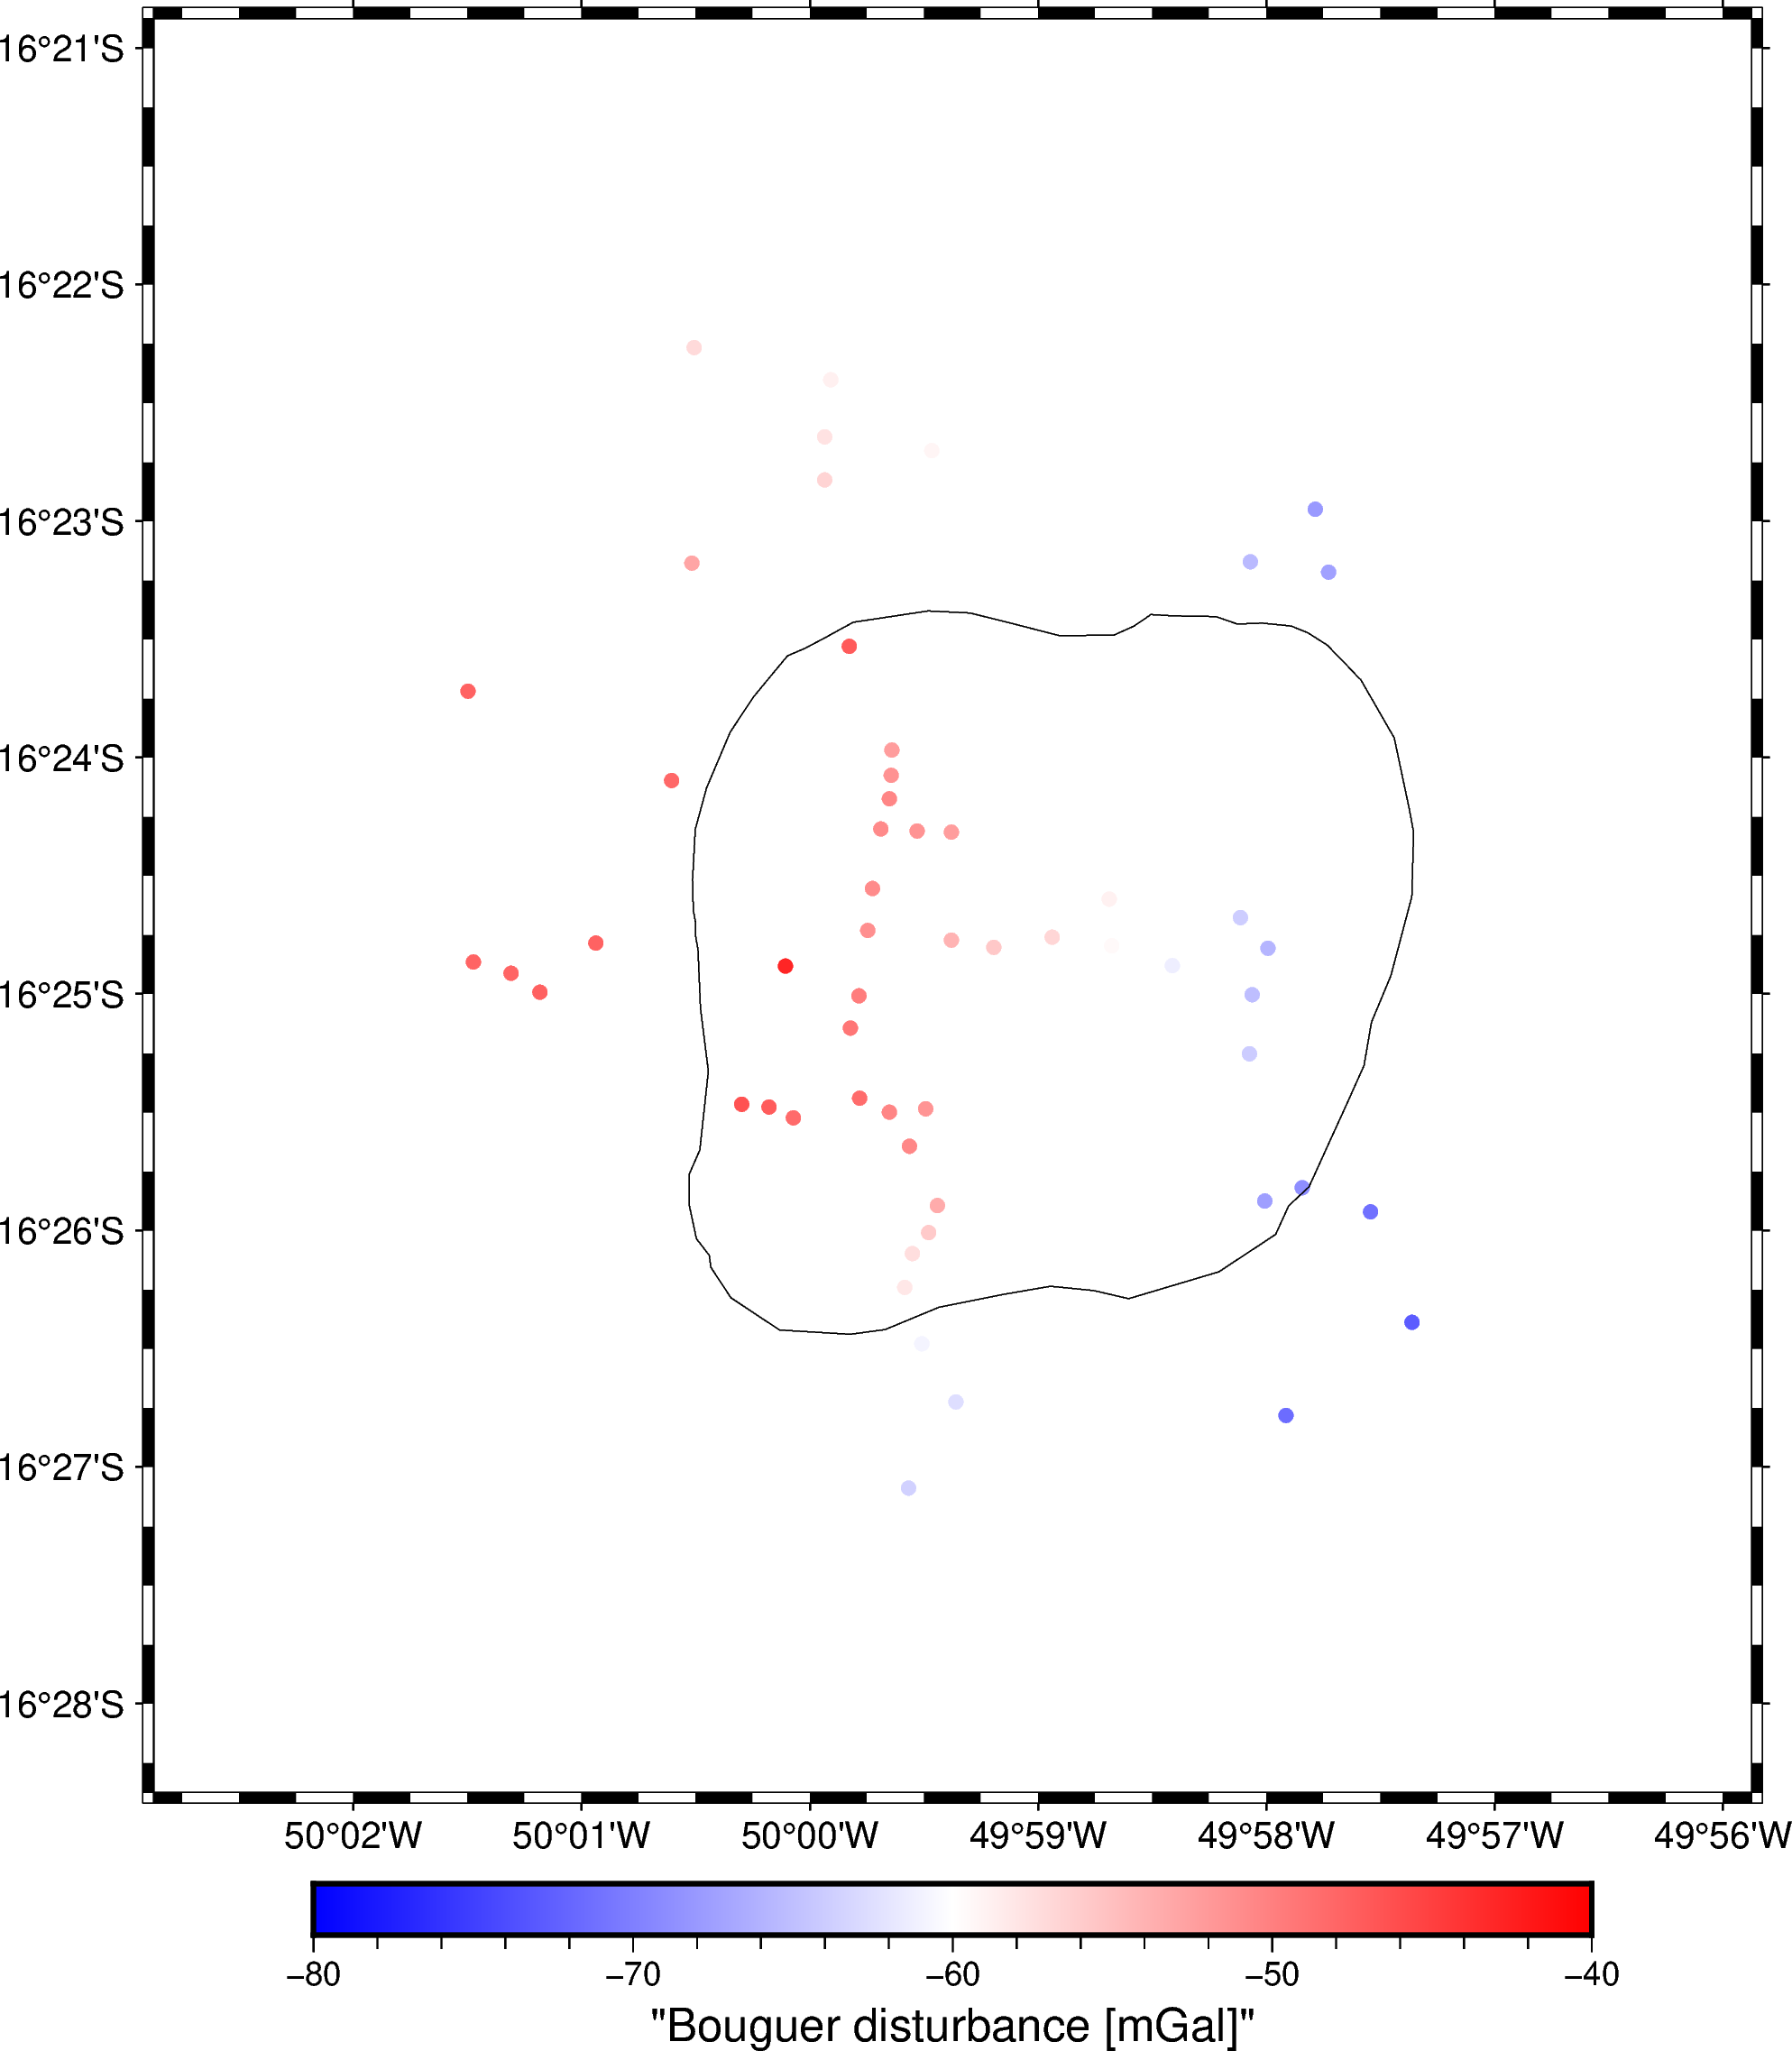

In [26]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_bouguer_mgal)
pygmt.makecpt(cmap="polar", series=[-80, -40])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    fill=data.gravity_bouguer_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
fig.plot(data=pluton, projection='M')
fig.show()

## Separação regional residual

In [27]:
# regional = vd.Trend(degree=1).fit(coordinates, data.gravity_bouguer_mgal)
# # regional = hm.upward_continuation()

# data = data.assign(
#     regional_mgal=regional.predict(coordinates),
# )
data = data.assign(
    residual_mgal=data.gravity_bouguer_mgal - data.regional_bouguer,
)
data.head(-5)

,Latitude,Longitude,Gravity,Elevation,Station,regional_bouguer,geoid_m,height_geometric_m,normal_gravity_mgal,gravity_disturbance_mgal,easting_m,northing_m,gravity_bouguer_mgal,residual_mgal
0,-16.386936,-49.962121,978224.514612,749.009,csg10_001,-69.416464,-7.49,741.519,978214.723451,9.791162,610833.211,8.187980e+06,-67.401222,2.015242
1,-16.386212,-49.967838,978217.706954,796.077,csg10_002,-68.666818,-7.49,788.587,978200.161347,17.545607,610223.040,8.188063e+06,-65.394012,3.272806
2,-16.382504,-49.963106,978220.923469,764.537,csg10_003,-69.304928,-7.49,757.047,978209.714654,11.208815,610730.539,8.188471e+06,-68.026055,1.278873
3,-16.431268,-49.966788,978230.218997,734.446,csg10_005,-70.231900,-7.55,726.896,978221.403479,8.815518,610309.782,8.183078e+06,-67.501382,2.730519
4,-16.430324,-49.964049,978236.632548,694.596,csg10_006,-70.673593,-7.55,687.046,978233.656649,2.975899,610602.829,8.183181e+06,-68.858840,1.814754
5,-16.432018,-49.959065,978239.055513,672.365,csg10_007,-71.489752,-7.55,664.815,978240.601048,-1.545535,611134.006,8.182991e+06,-71.107469,0.382282
6,-16.439817,-49.956038,978230.584075,703.841,csg10_008,-72.199308,-7.63,696.211,978231.292557,-0.708482,611452.745,8.182126e+06,-72.751935,-0.552627
7,-16.446370,-49.965245,978228.828473,721.347,csg10_009,-71.372820,-7.57,713.777,978226.191816,2.636657,610466.035,8.181406e+06,-71.533364,-0.160544
8,-16.424009,-49.996369,978219.024025,882.687,csg2_001,-65.968832,-7.38,875.307,978175.244475,43.779550,607155.320,8.183897e+06,-48.442171,17.526661
9,-16.425004,-49.994198,978215.202400,892.382,csg2_002,-66.194773,-7.39,884.992,978172.304187,42.898213,607386.576,8.183786e+06,-50.393816,15.800957


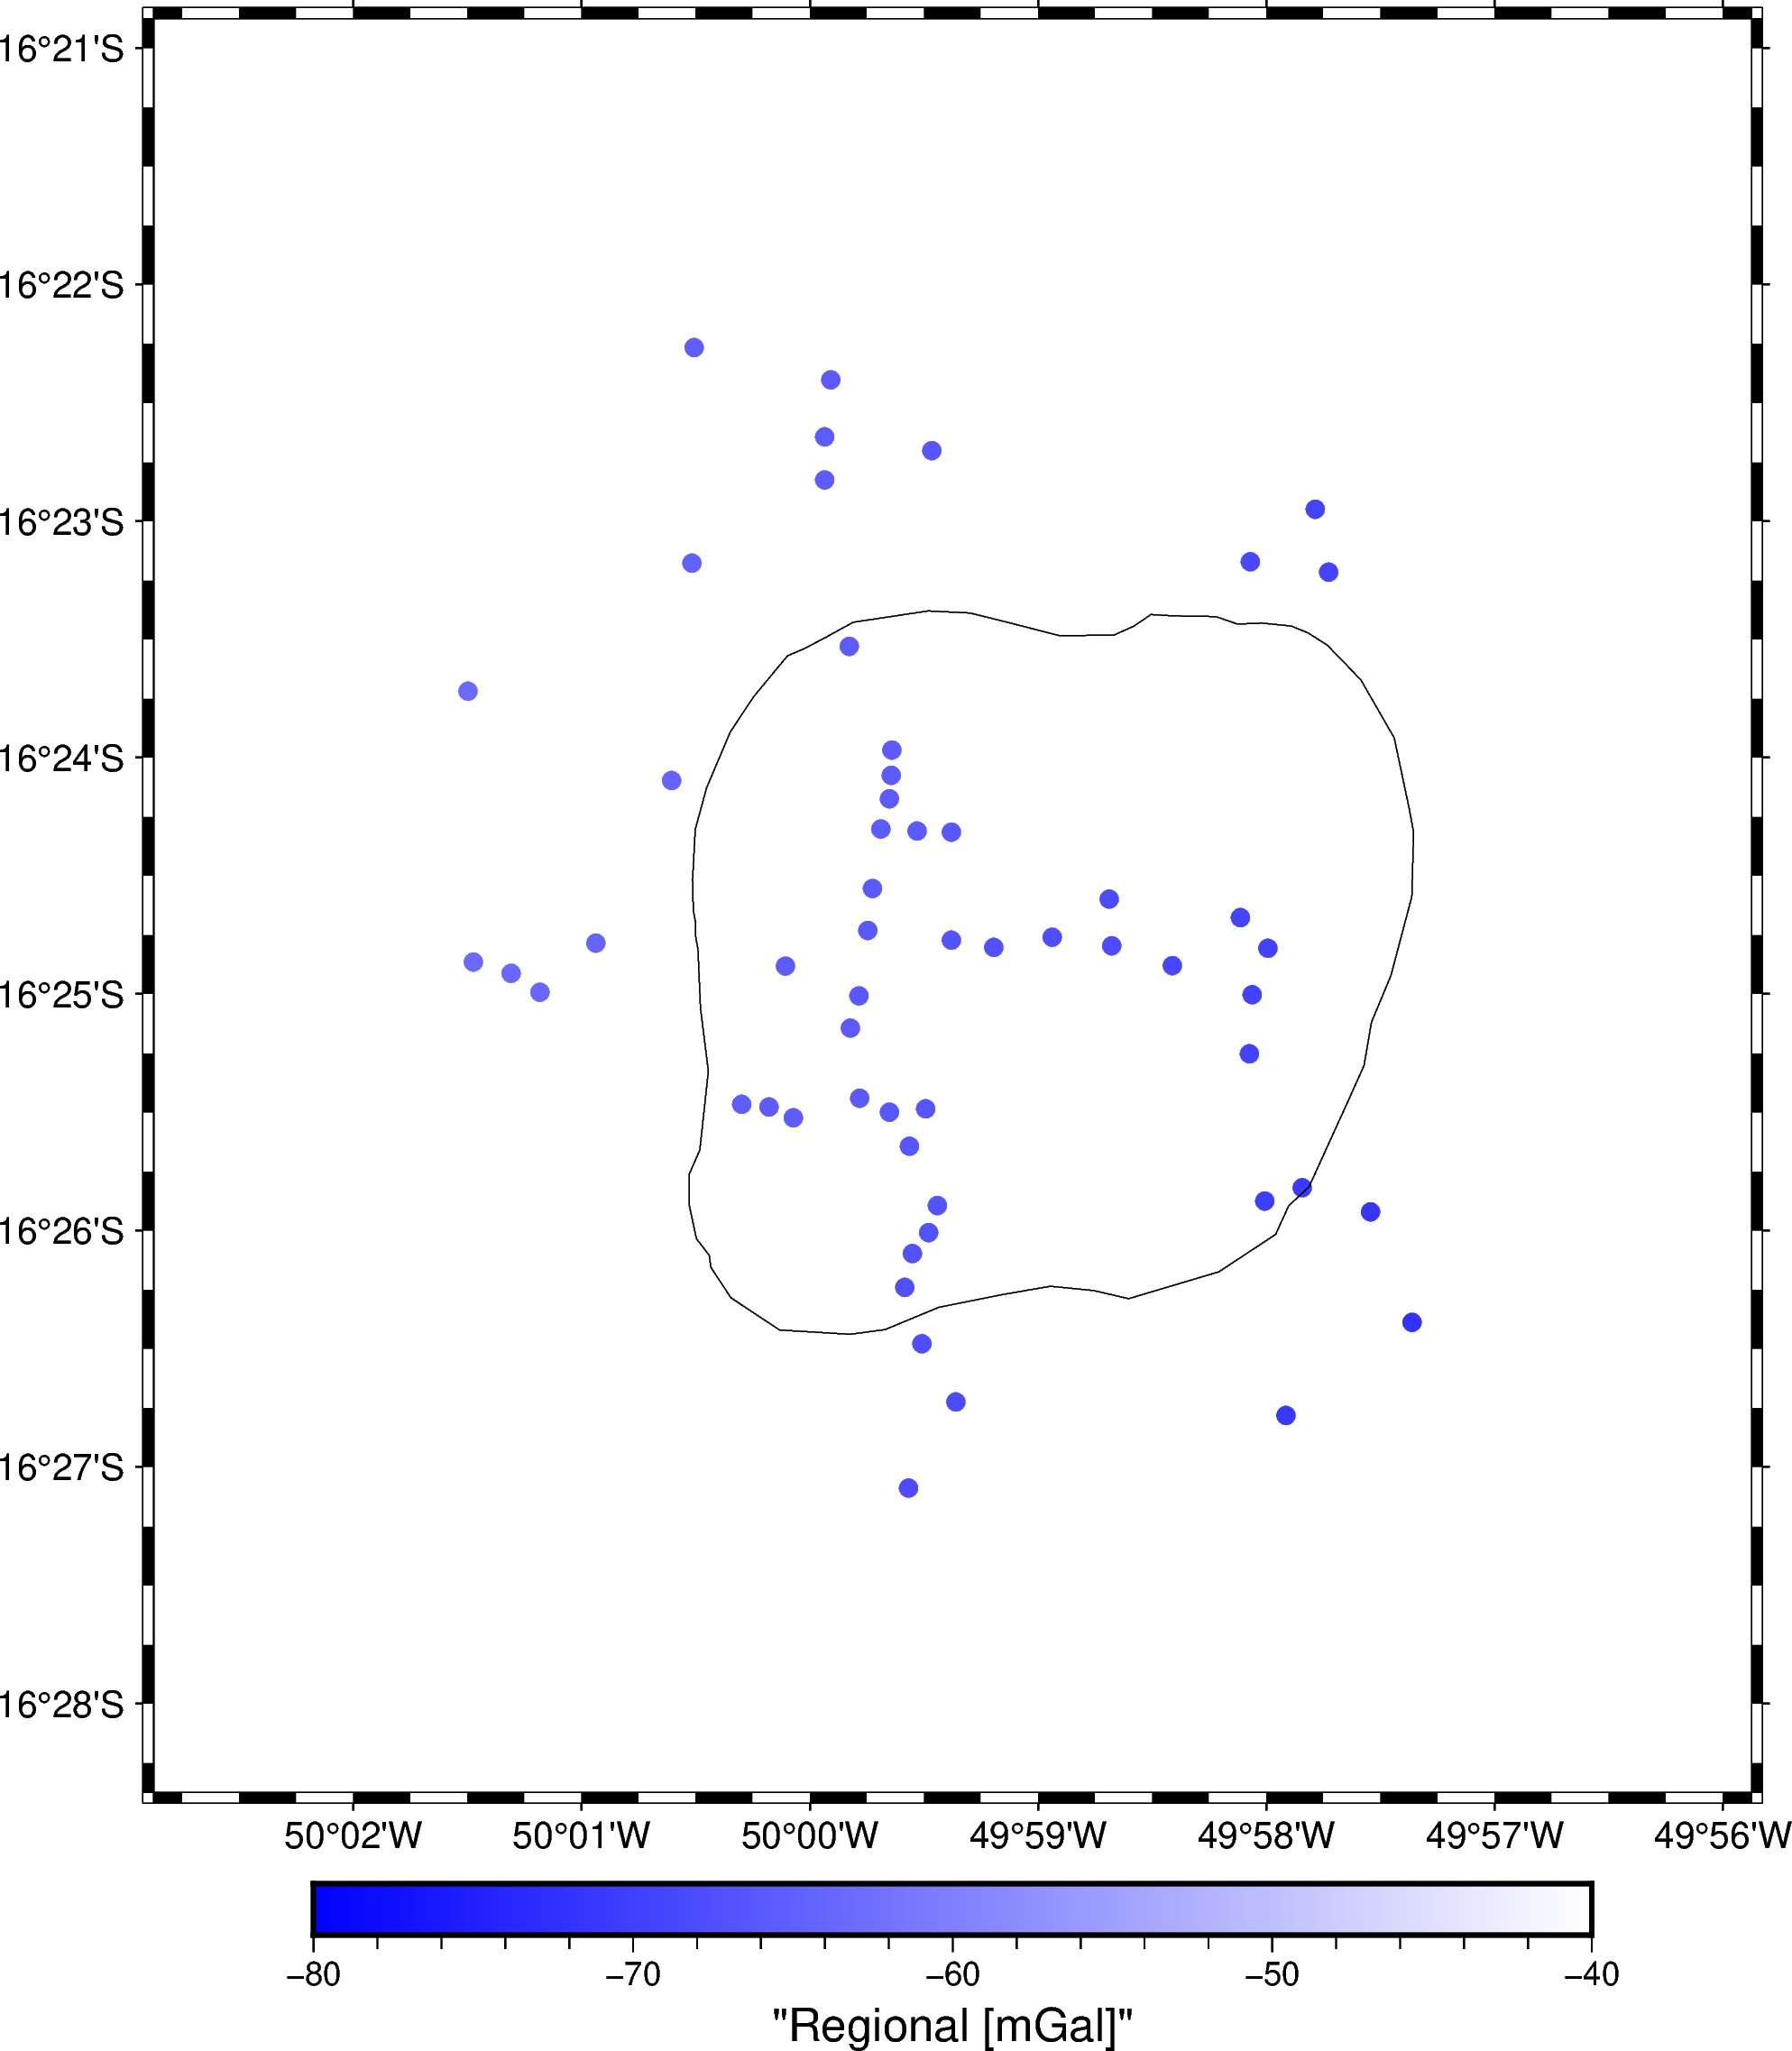

In [28]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.regional_bouguer)
pygmt.makecpt(cmap="polar+h", series=[-80, -40])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    fill=data.regional_bouguer,
    cmap=True,
    style="c5p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Regional [mGal]"')
fig.plot(data=pluton, projection='M')
fig.show()

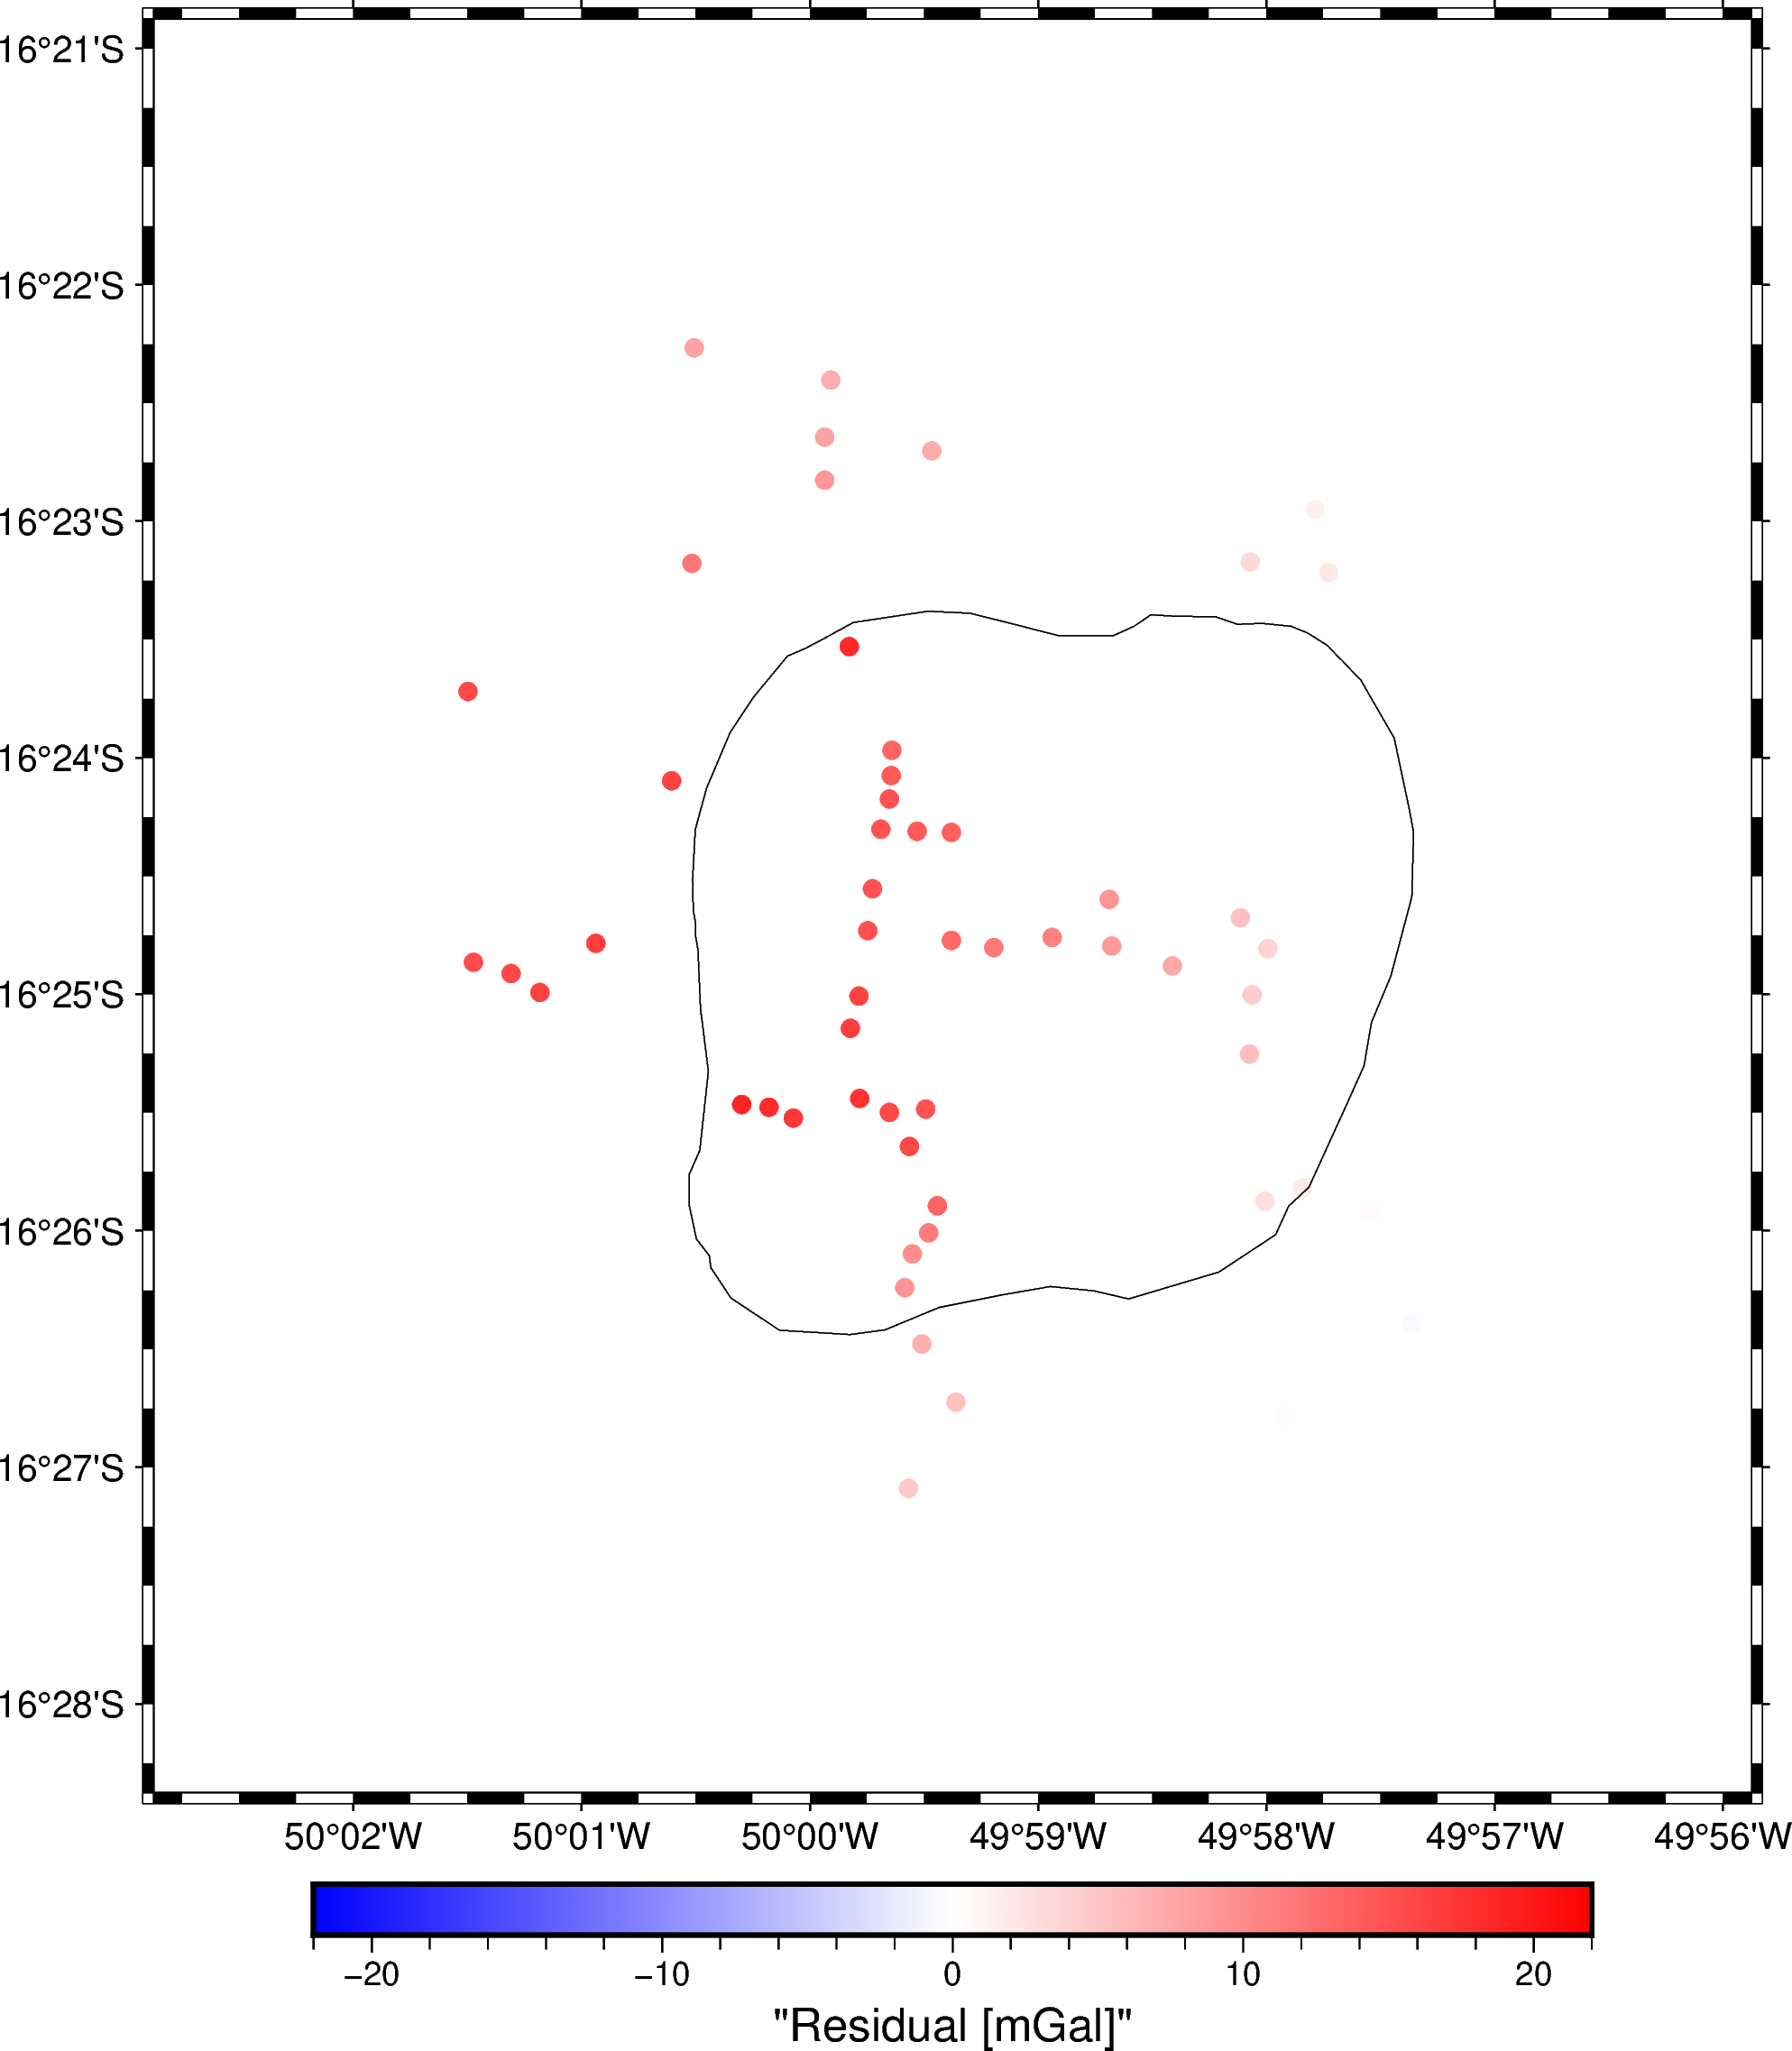

In [29]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.residual_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
pygmt.makecpt(cmap="polar", series=[-22, 22])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    fill=data.residual_mgal,
    cmap=True,
    style="c5p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Residual [mGal]"')
fig.plot(data=pluton, projection='M')
fig.show()

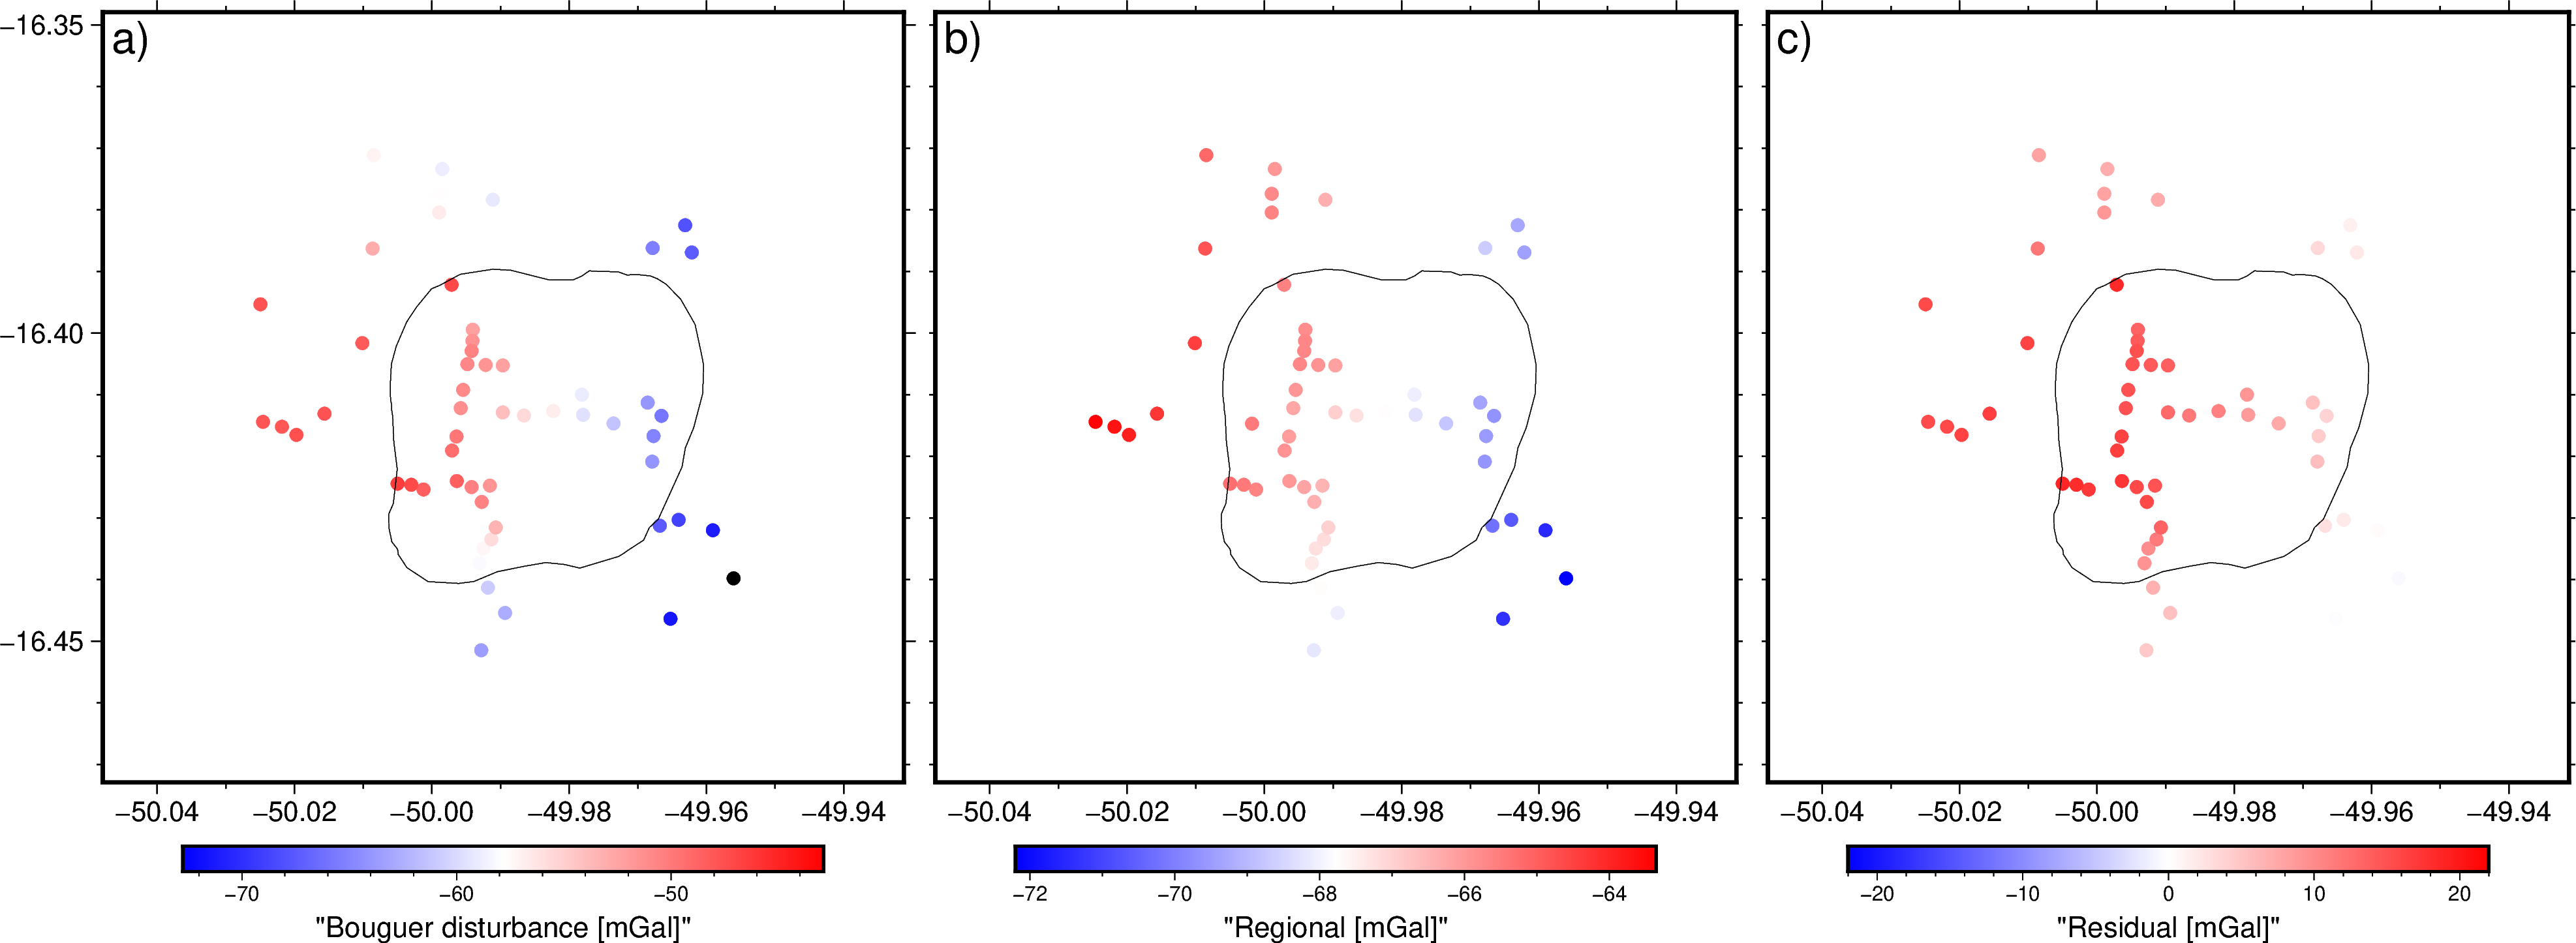

In [30]:
with plt.rc_context(mpl_rc):
    fig = pygmt.Figure()
    # fig.subplot(nrows=1, ncols=3, figsize=("15c", "5c"), frame="a")
    with fig.subplot(
        nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.05c"
    ):
        with fig.set_panel(panel=0):
            maxabs = vd.maxabs(data.gravity_bouguer_mgal)
            pygmt.makecpt(cmap="polar", series=[data.gravity_bouguer_mgal.min(), data.gravity_bouguer_mgal.max()])
            fig.plot(
                x=data.Longitude,
                y=data.Latitude,
                fill=data.gravity_bouguer_mgal,
                cmap=True,
                style="c5p",
                projection="X",
                frame=["WSne", "xaf", "yaf"],
            )
            fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
        with fig.set_panel(panel=1):
            maxabs = vd.maxabs(data.regional_bouguer)
            pygmt.makecpt(cmap="polar", series=[data.regional_bouguer.min(), data.regional_bouguer.max()])
            fig.plot(
                x=data.Longitude,
                y=data.Latitude,
                fill=data.regional_bouguer,
                cmap=True,
                style="c5p",
                projection="X",
                frame=["WSne", "xaf", "f"],
            )
            fig.colorbar(frame='af+l"Regional [mGal]"')
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
        with fig.set_panel(panel=2):
            maxabs = vd.maxabs(data.residual_mgal)
            pygmt.makecpt(cmap="polar", series=[-22, 22])
            fig.plot(
                x=data.Longitude,
                y=data.Latitude,
                fill=data.residual_mgal,
                cmap=True,
                style="c5p",
                projection="X",
                frame=["WSne", "xaf", "f"],
            )
            fig.colorbar(frame='af+l"Residual [mGal]"')
            
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")


fig.savefig(image_dir/'gravity_maps.png', dpi=300)
fig.show()


## Interpolação com fontes equivalentes

In [31]:
eqs = hm.EquivalentSources(damping=1.0, depth=2.5e3)
eqs.fit((data.easting_m, data.northing_m, data.height_geometric_m),  data.residual_mgal) # data.gravity_bouguer_mgal)

# eqs = hm.EquivalentSources(damping=1.0, depth=3.5e3)
# eqs.fit((data.easting_m, data.northing_m, data.height_geometric_m), data.gravity_bouguer_mgal)# data.residual_mgal)

EquivalentSources(damping=1.0, depth=2500.0)

In [32]:
# Interpolar extra coord a partir da topografia
region_pad_2 = region_pad#vd.pad_region(region, pad=-0.05)
grid_extra_coord = vd.grid_coordinates(region_pad, spacing= 2 / 3600)
# grid_extra_coord = vd.grid_coordinates(region, spacing= 2 / 3600)

interpolator = vd.KNeighbors()
topography_table = vd.grid_to_table(topography)
interpolator.fit((topography_table.longitude, topography_table.latitude), topography_table.z)
extra_coord=interpolator.predict((grid_extra_coord[0], grid_extra_coord[1]))

# geoid_values = np.reshape(geoid_1.elevation, topography.shape)
coordinates_grid = ([grid_extra_coord[0], grid_extra_coord[1], extra_coord])

In [33]:
residual_grid = eqs.grid(
    # coordinates=vd.grid_coordinates(region_pad_2, spacing=5 / 3600, extra_coords=1.0e3),
    # coordinates=vd.grid_coordinates(region_pad_2, spacing=10 / 3600, extra_coords=1.0e3),
    coordinates=coordinates_grid,
    data_names="gravity_residual",
    dims=("latitude", "longitude"),
    projection=projection,
)
residual_grid

<xarray.Dataset> Size: 766kB
Dimensions:           (latitude: 226, longitude: 211)
Coordinates:
  * longitude         (longitude) float64 2kB -50.05 -50.05 ... -49.93 -49.93
  * latitude          (latitude) float64 2kB -16.47 -16.47 ... -16.35 -16.35
    upward            (latitude, longitude) float64 381kB 780.0 782.0 ... 787.0
Data variables:
    gravity_residual  (latitude, longitude) float64 381kB 4.239 4.248 ... 1.311
Attributes:
    metadata:  Generated by EquivalentSources(damping=1.0, depth=2500.0)

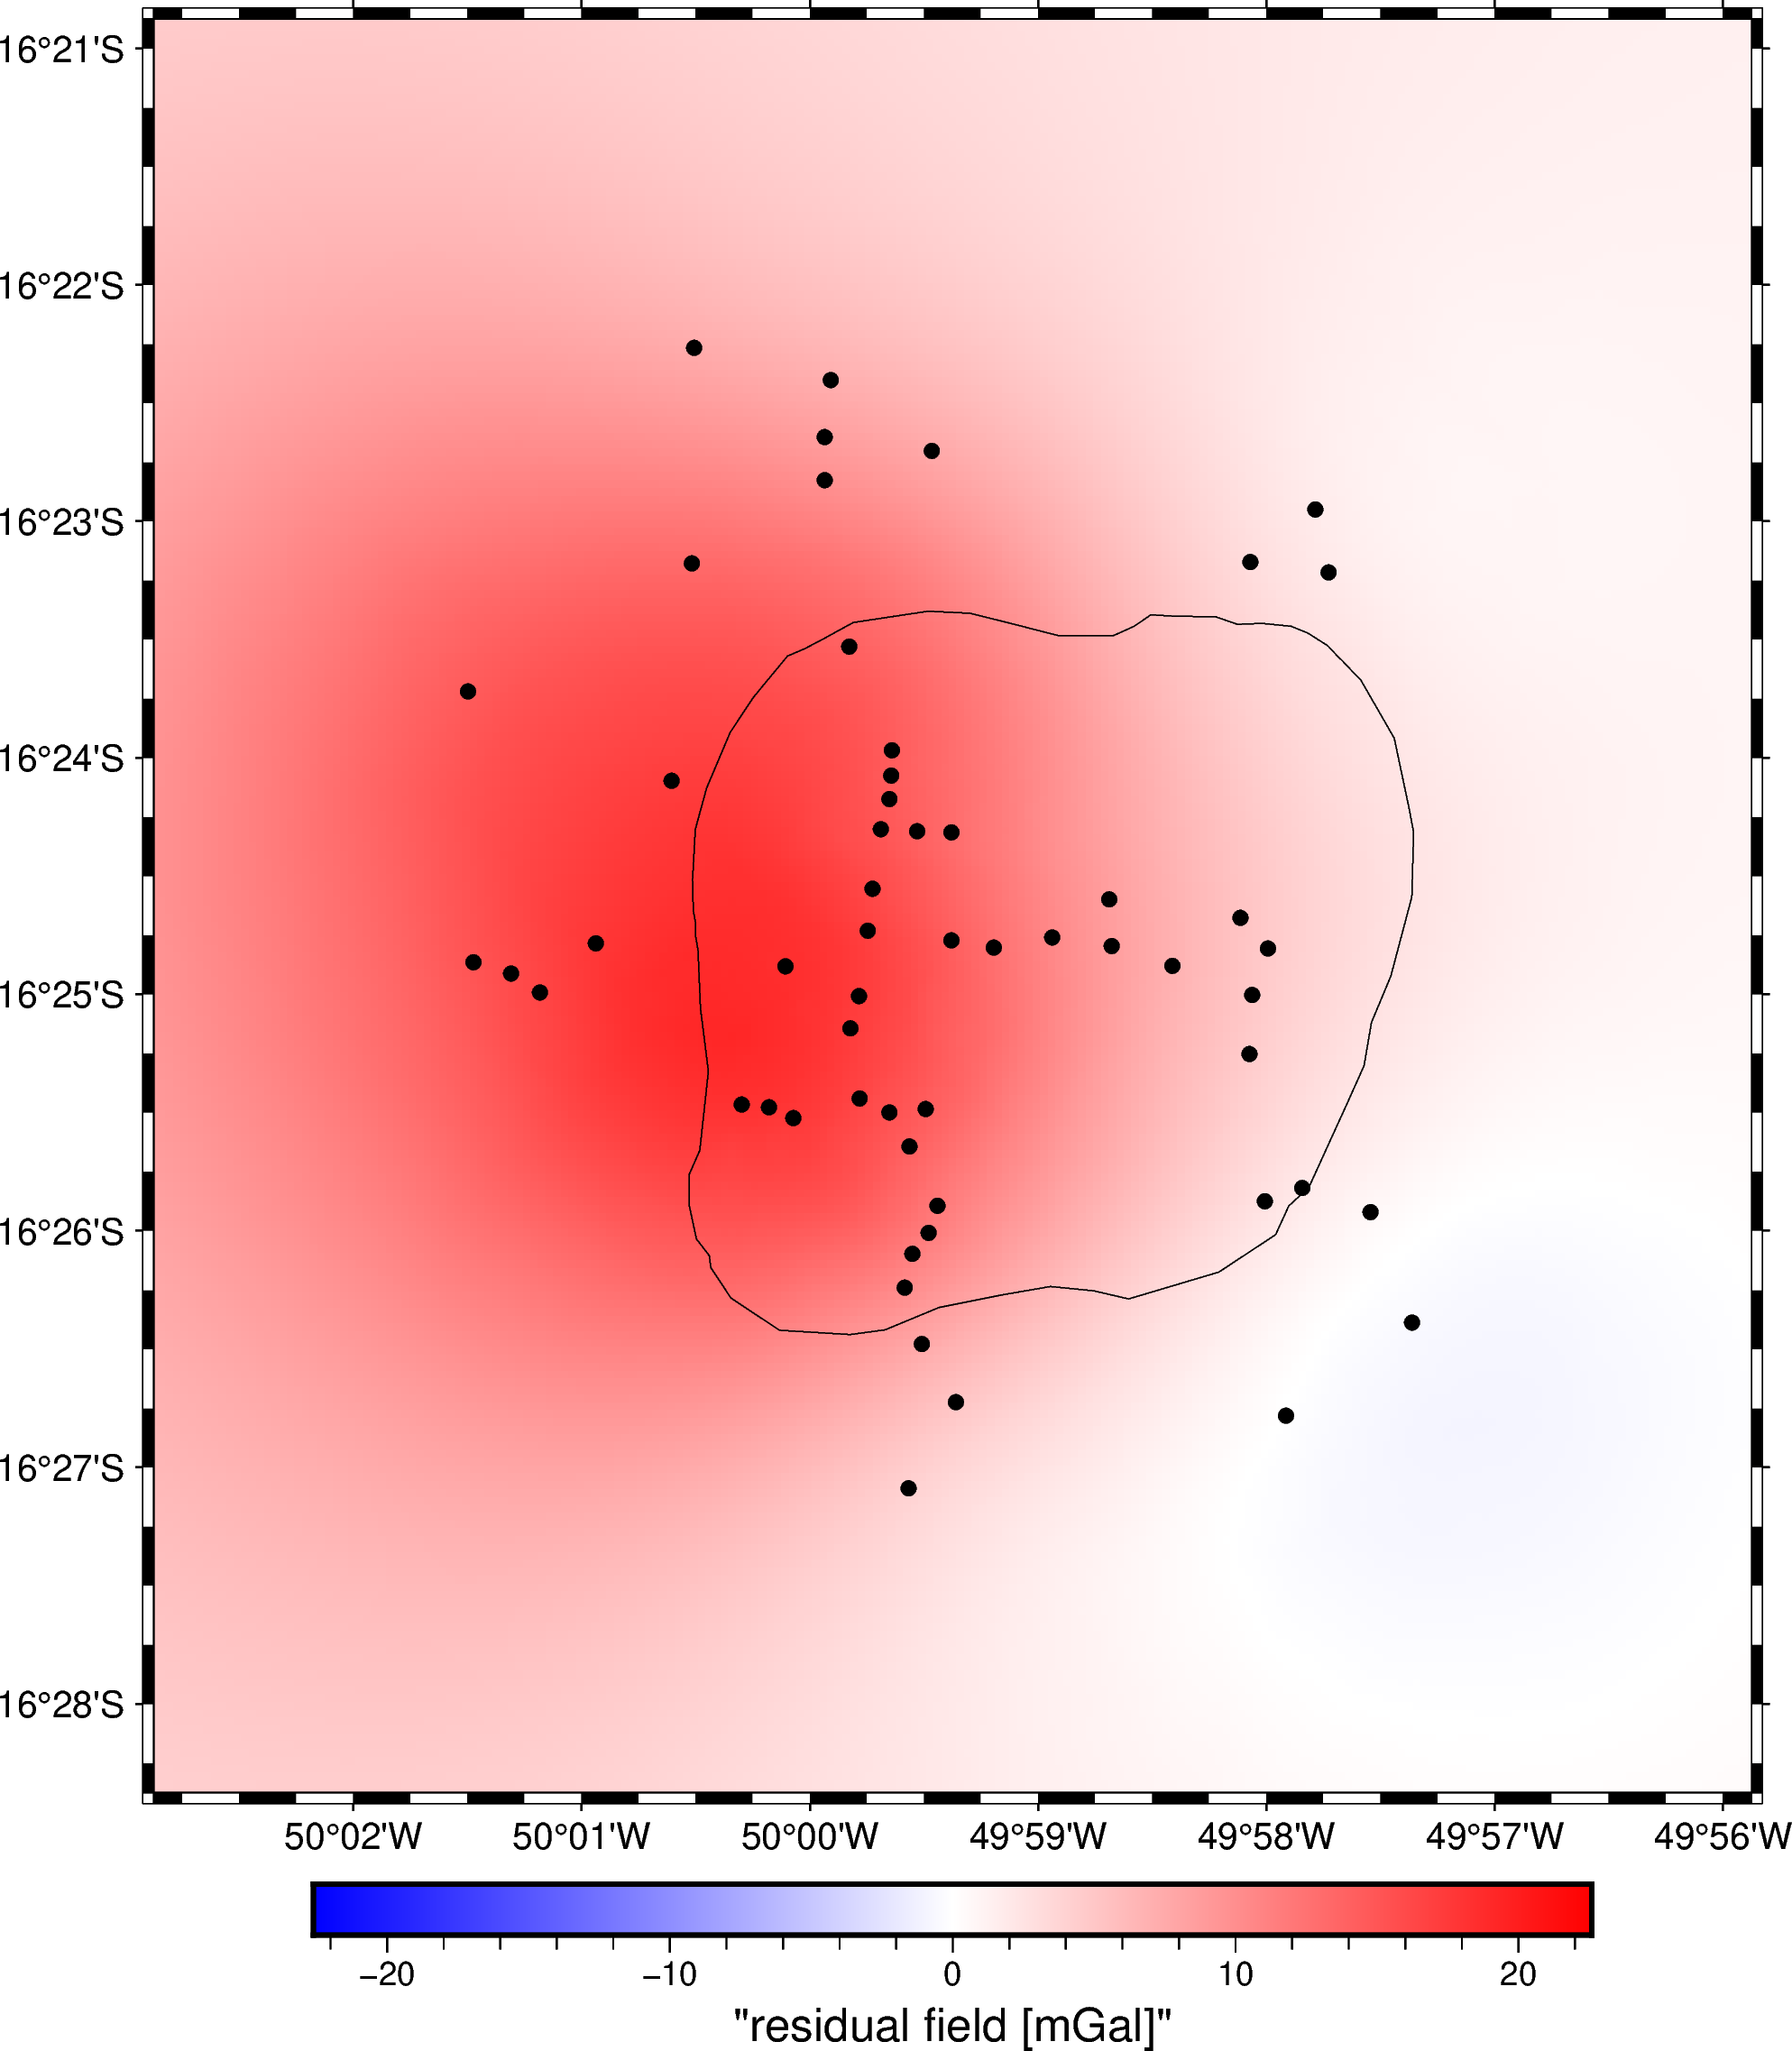

In [34]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.residual_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs], no_bg=True)
# pygmt.makecpt(cmap="polar+h", series=[-85, -40], no_bg=True)
fig.grdimage(
    residual_grid.gravity_residual,
    # shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
    region=vd.pad_region(region_pad, pad=0.0)#pad=-0.085)
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.15c",
    fill="black",
)
fig.plot(data=pluton, projection='M')
 
fig.show()

In [35]:
## Validação cruzada entre dados de grav residual e camada equivalente
r2_score = np.mean(
    vd.cross_val_score(
        eqs,
        coordinates,
        data.residual_mgal,
    )
)
print(f'O R² do modelo de camada equivalente para os dados é de: {r2_score:.3f}')

O R² do modelo de camada equivalente para os dados é de: 0.928


In [36]:
residual_grid

<xarray.Dataset> Size: 766kB
Dimensions:           (latitude: 226, longitude: 211)
Coordinates:
  * longitude         (longitude) float64 2kB -50.05 -50.05 ... -49.93 -49.93
  * latitude          (latitude) float64 2kB -16.47 -16.47 ... -16.35 -16.35
    upward            (latitude, longitude) float64 381kB 780.0 782.0 ... 787.0
Data variables:
    gravity_residual  (latitude, longitude) float64 381kB 4.239 4.248 ... 1.311
Attributes:
    metadata:  Generated by EquivalentSources(damping=1.0, depth=2500.0)

In [37]:
# g_east, g_north = projection(*coordinates_grid[:2])
# g_up = coordinates_grid[2]


# # ds = xr.Dataset(
# #     {
# #         "gravity": (("y", "x"), residual_grid.gravity_residual.values),
# #         # "upward": (("y", "x"), g_up)
# #     },
# #     coords={
# #         "northing": (("y", "x"), g_north),
# #         "easting": (("y", "x"), g_east),
# #               "upward": (("y", "x"), g_up)
# #     }
# # )


# # Defina os arrays x e y
# x = g_east[0, :]   # assume que g_east é uma matriz com coordenadas na dimensão x
# y = g_north[:, 0]  # assume que g_north é uma matriz com coordenadas na dimensão y

# ds = xr.Dataset(
#     {
#         "gravity": (("y", "x"), residual_grid.gravity_residual.values),
#     },
#     coords={
#         # "easting": ("x", x),
#         # "northing": ("y", y),
#         "northing": (("y", "x"), g_north),
#         "easting": (("y", "x"), g_east),
#         "upward": (("y", "x"), g_up)
#     }
# )


In [38]:
# ds.gravity.min()
# ds

In [39]:
# upward_cont = hm.upward_continuation(ds.gravity,  0.008)
# print(upward_cont.max())

In [40]:
# upward_cont

# Calculate derivatives and gradients (new)

## Calculate derivatives

In [41]:
# grid_coords = vd.grid_coordinates(region, spacing=2 / 60, extra_coords=2.3e3)
g_east, g_north = projection(*coordinates_grid[:2])
g_up = coordinates_grid[2]

delta = 10
deast = (
      eqs.predict((g_east + delta, g_north, g_up))
    - eqs.predict((g_east - delta, g_north, g_up))
) / (2 * delta)

dnorth = (
      eqs.predict((g_east, g_north + delta, g_up))
    - eqs.predict((g_east, g_north - delta, g_up))
) / (2 * delta)



delta = 5
dup = (
      eqs.predict((g_east, g_north, g_up + delta))
    - eqs.predict((g_east, g_north, g_up - delta))
) / (2 * delta)


derivatives = vd.make_xarray_grid(coordinates_grid, (deast, dnorth, -dup), 
                                  data_names=["derivative_easting", "derivative_northing", "derivative_upward"],
                                  extra_coords_names="upward")

derivatives.derivative_easting.attrs = {"units": "mGal/m"}
derivatives.derivative_northing.attrs = {"units": "mGal/m"}
derivatives.derivative_upward.attrs = {"units": "mGal/m"}


## Calculate total and horizontal gradients

In [42]:
derivatives = derivatives.assign(TG=np.sqrt(derivatives.derivative_easting**2  +
                                            derivatives.derivative_northing**2 +
                                            derivatives.derivative_upward**2
                                               ))

derivatives = derivatives.assign(HG=np.sqrt(derivatives.derivative_easting**2  +
                                            derivatives.derivative_northing**2
                                               ))

derivatives.HG.attrs = {"units": "mGal/m"}
derivatives.TG.attrs = {"units": "mGal/m"}

In [43]:
derivatives

<xarray.Dataset> Size: 2MB
Dimensions:              (northing: 226, easting: 211)
Coordinates:
  * easting              (easting) float64 2kB -50.05 -50.05 ... -49.93 -49.93
  * northing             (northing) float64 2kB -16.47 -16.47 ... -16.35 -16.35
    upward               (northing, easting) float64 381kB 780.0 782.0 ... 787.0
Data variables:
    derivative_easting   (northing, easting) float64 381kB 0.000168 ... -6.91...
    derivative_northing  (northing, easting) float64 381kB 0.0006407 ... 9.69...
    derivative_upward    (northing, easting) float64 381kB 0.0001645 ... -0.0...
    TG                   (northing, easting) float64 381kB 0.0006825 ... 0.00...
    HG                   (northing, easting) float64 381kB 0.0006624 ... 0.00...

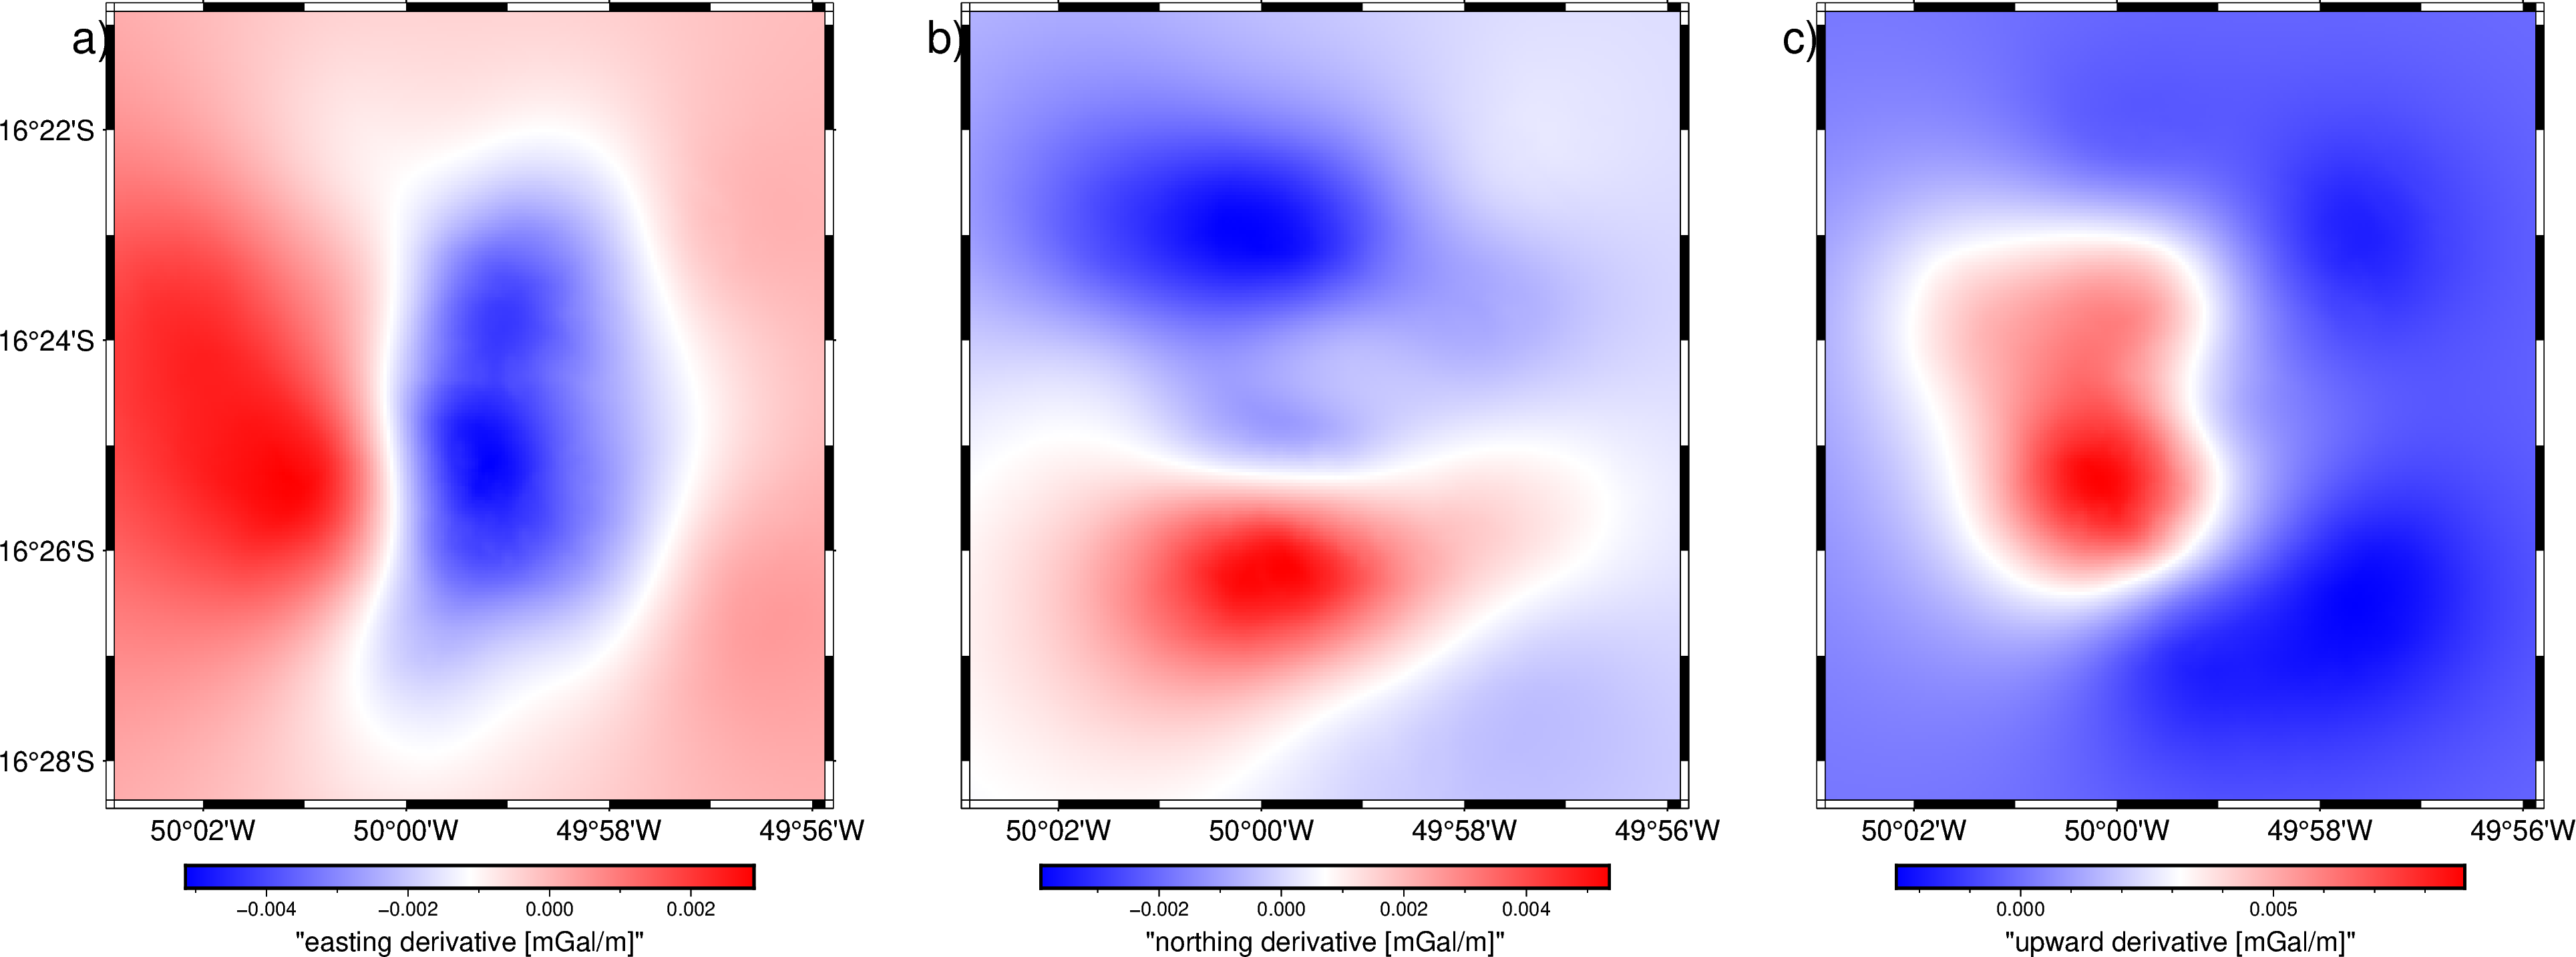

In [44]:
fig = pygmt.Figure()
# fig.subplot(nrows=1, ncols=3, figsize=("15c", "5c"), frame="a")
with fig.subplot(
    nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="0.01c"
):
    with fig.set_panel(panel=0):
        fig.grdimage(derivatives.derivative_easting, projection="M", cmap="polar", frame=["WSne", "xaf", "yaf"],
                    region= region_pad_2)# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
        fig.colorbar(frame='af+l"easting derivative [mGal/m]"')

    with fig.set_panel(panel=1):
        fig.grdimage(derivatives.derivative_northing, projection="M", cmap="polar", frame=["WSne", "xaf+lx-axis", "f+ly-axis"],
                    region= region_pad_2)
        fig.colorbar(frame='af+l"northing derivative [mGal/m]"')

    with fig.set_panel(panel=2):
        fig.grdimage(derivatives.derivative_upward, projection="M", cmap="polar", frame=["WSne", "xaf+lx-axis", "f+ly-axis"],
                    region= region_pad_2)
        fig.colorbar(frame='af+l"upward derivative [mGal/m]"')

# fig.savefig('teste.png', dpi=300)
fig.show()


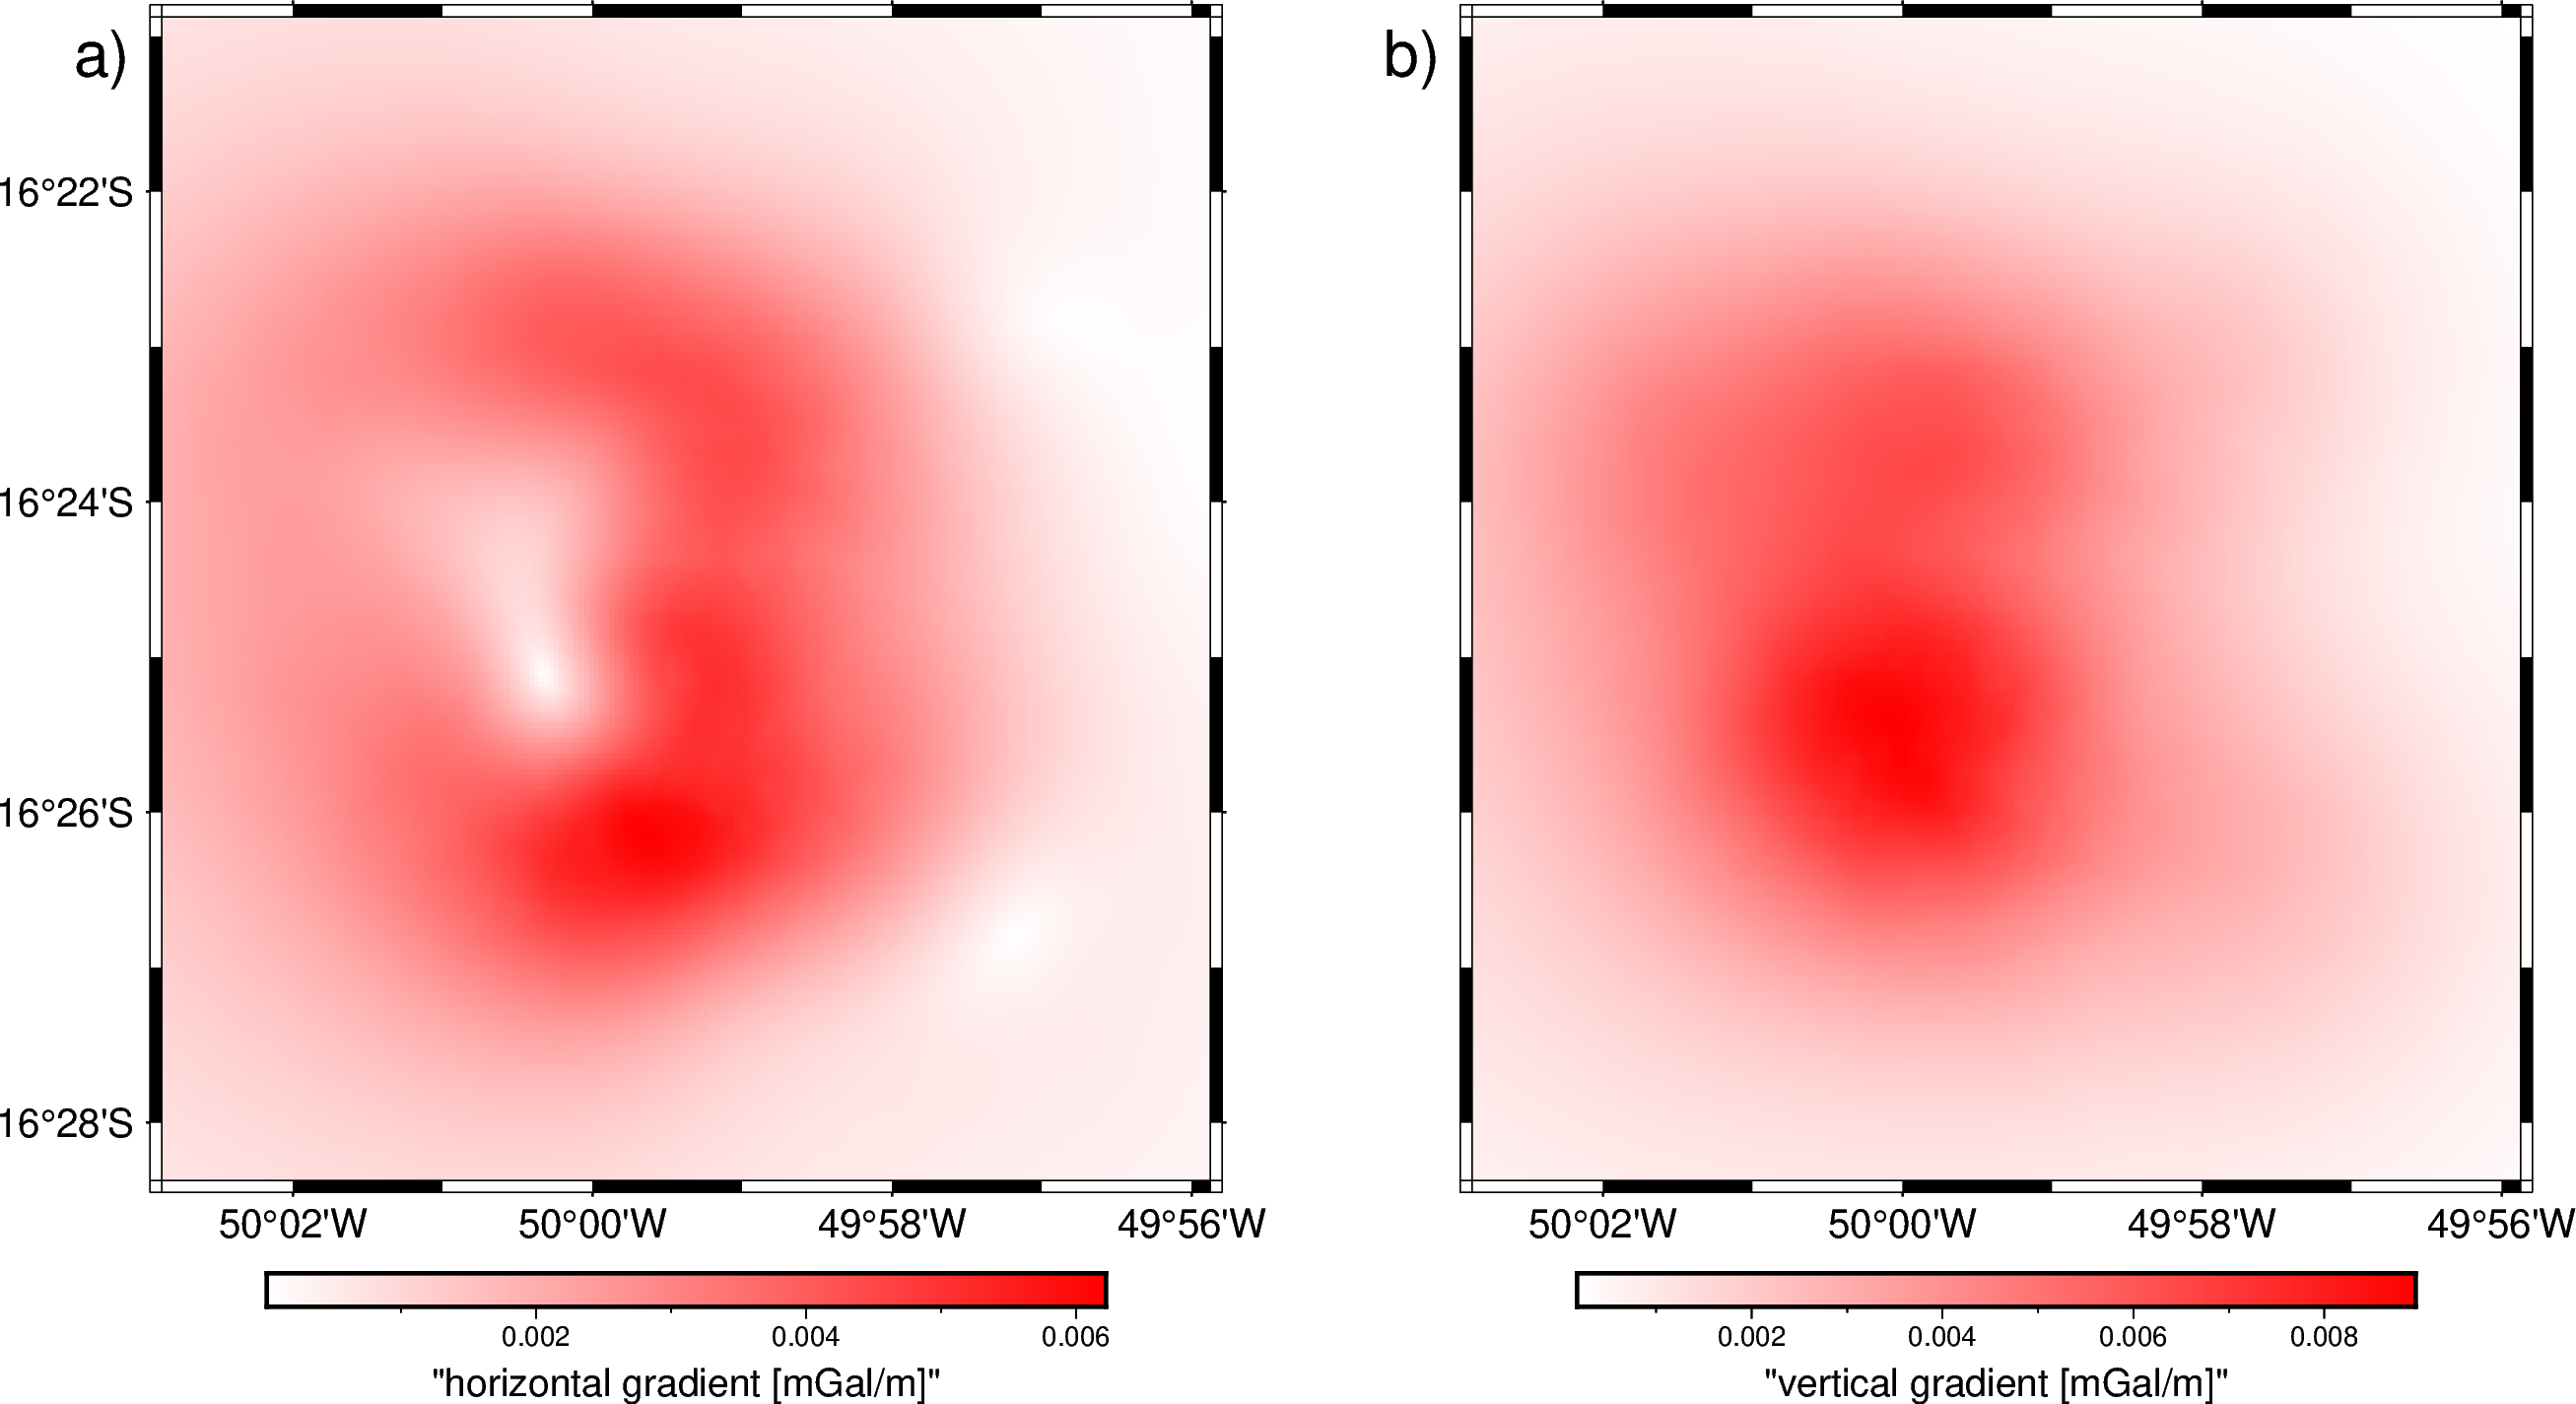

In [45]:
fig = pygmt.Figure()
# fig.subplot(nrows=1, ncols=3, figsize=("15c", "5c"), frame="a")
with fig.subplot(
    nrows=1, ncols=2, figsize=("22c", "10c"), autolabel=True, margins="0.01c"
):
    with fig.set_panel(panel=0):
        fig.grdimage(derivatives.HG, projection="M", cmap="polar+h", frame=["WSne", "xaf", "yaf"],
                    region= region_pad_2)# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
        fig.colorbar(frame='af+l"horizontal gradient [mGal/m]"')

    with fig.set_panel(panel=1):
        fig.grdimage(derivatives.TG, projection="M", cmap="polar+h", frame=["WSne", "xaf+lx-axis", "f+ly-axis"],
                    region= region_pad_2)
        fig.colorbar(frame='af+l"vertical gradient [mGal/m]"')

fig.show()

## Report's plot

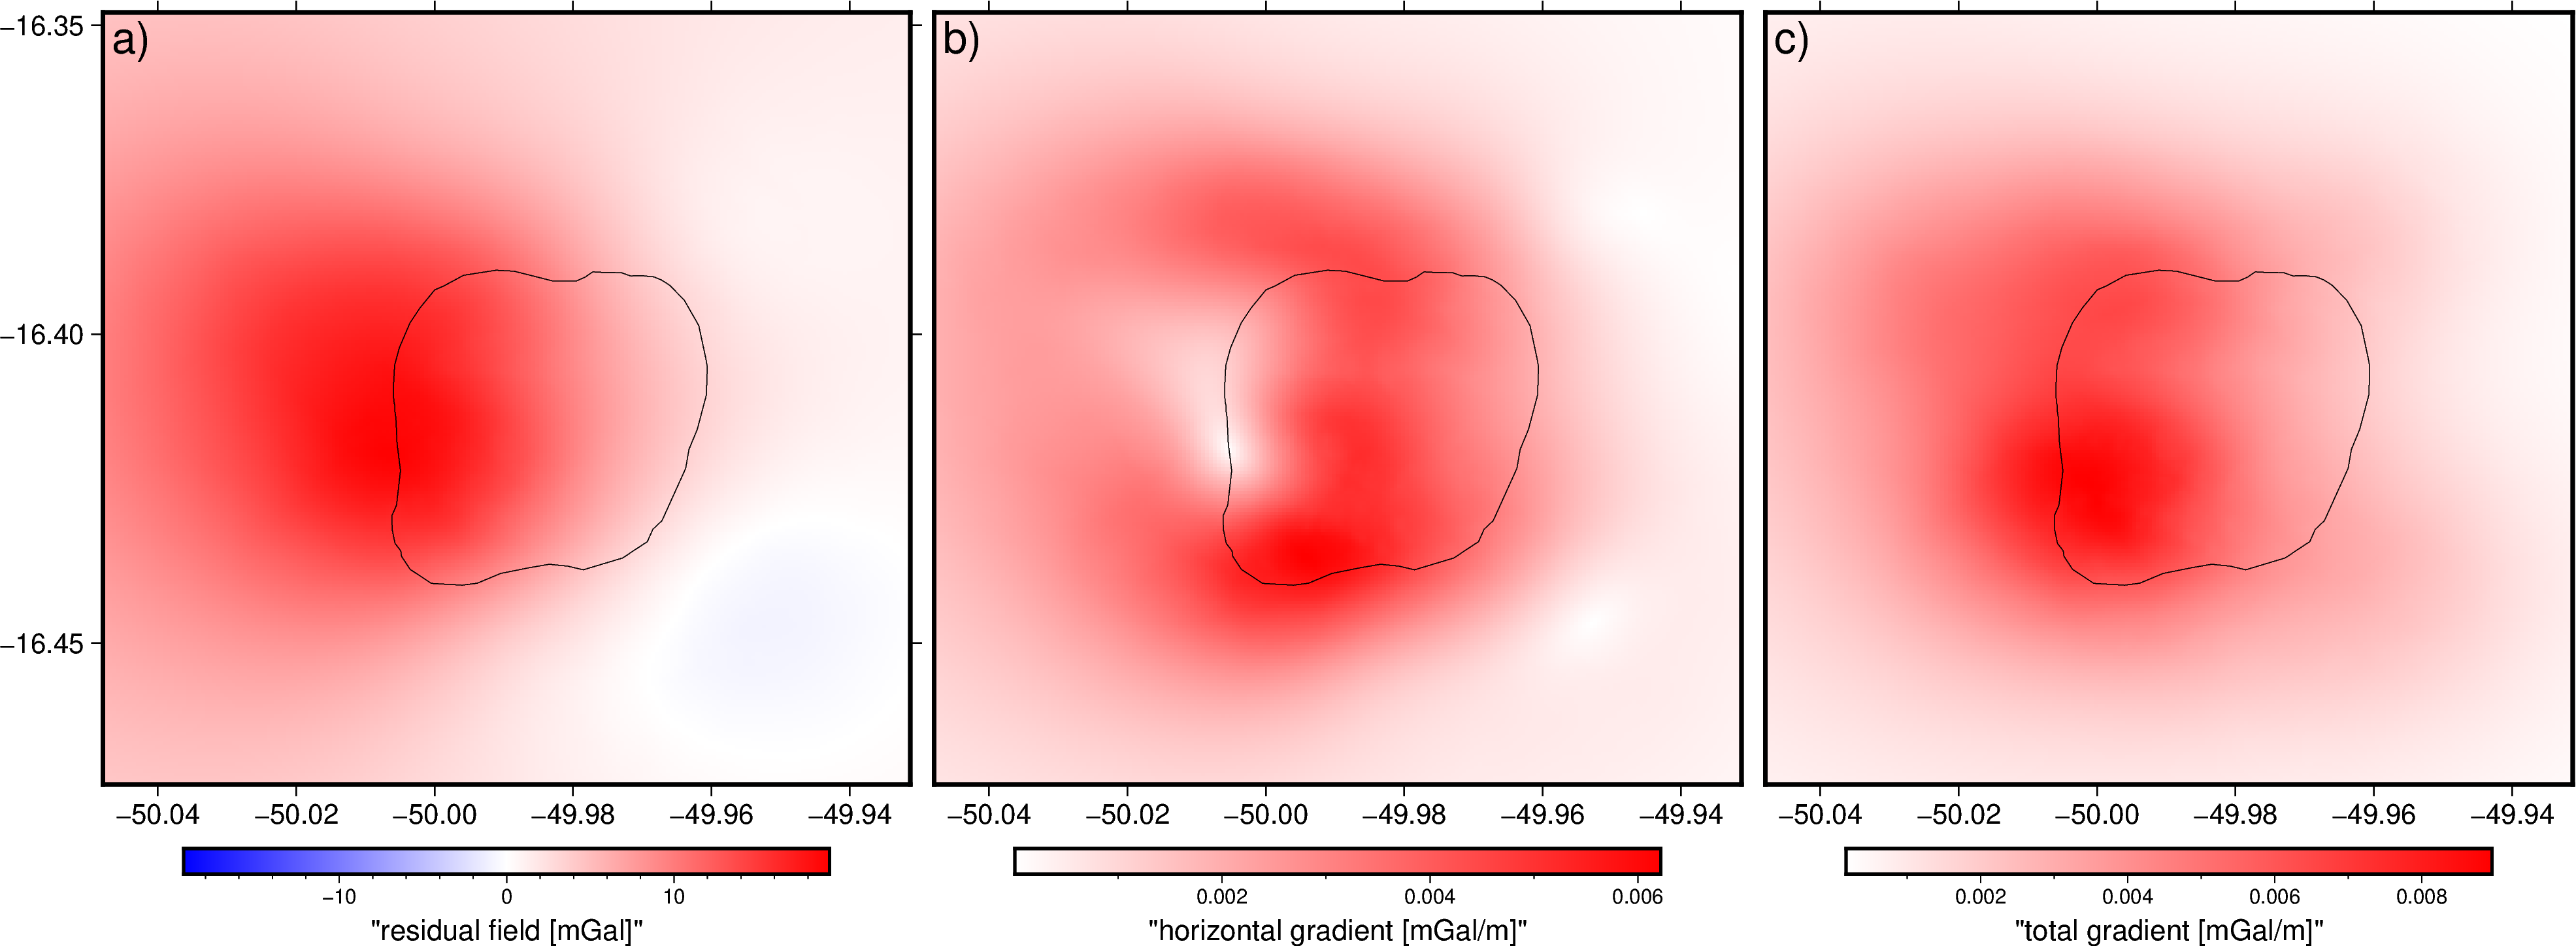

In [46]:
with plt.rc_context(mpl_rc):

    fig = pygmt.Figure()
    with fig.subplot(
        nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.1c/0.99c"
    ):
        
        with fig.set_panel(panel=0):
            scale = vd.maxabs(residual_grid.gravity_residual)+0.1
            pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
            fig.grdimage(
                residual_grid.gravity_residual,
                # shading="+a45+nt0.15",
                projection="X",
                frame=["WSne", "xaf2.5", "yaf2.5"],
                region=region_pad_2
            )
            fig.colorbar(frame='af+l"residual field [mGal]"')
            fig.plot(data=pluton, projection='M')
        

        with fig.set_panel(panel=1):
            fig.grdimage(derivatives.HG, projection="X", cmap="polar+h", frame=["WSne", "xaf2.5", "yf2.5"],
                        region= region_pad_2)# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
            fig.colorbar(frame='af+l"horizontal gradient [mGal/m]"')
            fig.plot(data=pluton, projection='M')

        with fig.set_panel(panel=2):
            fig.grdimage(derivatives.TG, projection="X", cmap="polar+h", frame=["WSne", "xaf2.5", "f2.5"],
                        region= region_pad_2)
            fig.colorbar(frame='af+l"total gradient [mGal/m]"')
            fig.plot(data=pluton, projection='M')


fig.savefig(image_dir/'panel_data_HG_TG.png', dpi=300)
fig.show()

In [47]:
data
proc_dir = pathlib.Path("..") / "report" / "processing_data"
data.to_csv(proc_dir / 'processed_data_table.csv', sep=':', index=False)

In [48]:
residual_grid_table = vd.grid_to_table(residual_grid)
residual_grid_table
residual_grid_table.to_csv(proc_dir / 'residual_grid.csv', sep=':', index=False)

In [49]:
# derivatives_table = vd.grid_to_table(derivatives)
# derivatives_table
# derivatives_table.to_csv(proc_dir / 'grid_gradientes_modelo_1.csv', sep=':', index=False)

# Export data for the SimPEG inversion

In [50]:
residual_grid_table.head(5)

,latitude,longitude,upward,gravity_residual
0,-16.472917,-50.047917,780.0,4.238630
1,-16.472917,-50.047361,782.0,4.247944
2,-16.472917,-50.046806,789.0,4.256133
3,-16.472917,-50.046250,796.0,4.264008
4,-16.472917,-50.045694,806.0,4.271049


In [51]:
region_cut = vd.pad_region(region, pad=-0.125)

selected_slices = residual_grid.sel(
    longitude=slice(region_cut[0], region_cut[1]),
    latitude=slice(region_cut[2], region_cut[3])
)


residual_grid_table = vd.grid_to_table(selected_slices)


easting_res_grid, northing_res_grid = projection(residual_grid_table.longitude.values, 
                                                 residual_grid_table.latitude.values)
residual_grid_table = residual_grid_table.assign(easting_m=easting_res_grid,
                                                 northing_m=northing_res_grid)
residual_grid_table.head(5)

,latitude,longitude,upward,gravity_residual,easting_m,northing_m
0,-16.472917,-50.047917,780.0,4.238630,601625.792594,8.178513e+06
1,-16.472917,-50.047361,782.0,4.247944,601685.097453,8.178512e+06
2,-16.472917,-50.046806,789.0,4.256133,601744.402321,8.178512e+06
3,-16.472917,-50.046250,796.0,4.264008,601803.707197,8.178512e+06
4,-16.472917,-50.045694,806.0,4.271049,601863.012080,8.178511e+06


In [52]:
residual_grid_table[['easting_m', 
                     'northing_m', 
                     'upward', 
                     'gravity_residual']].iloc[::10].to_csv(data_dir/'obs_data_inv.csv', 
                                                           index=False, header=False, sep=' ')


In [53]:
## Topography

In [54]:
selected_slices = topography.sel(
    longitude=slice(region_cut[0], region_cut[1]),
    latitude=slice(region_cut[2], region_cut[3])
)


topography_table = vd.grid_to_table(selected_slices)

easting_topo_grid, northing_topo_grid = projection(topography_table.longitude.values, 
                                                 topography_table.latitude.values)
topography_table = topography_table.assign(easting_m=easting_topo_grid,
                                                 northing_m=northing_topo_grid)
topography_table.head(5)

,latitude,longitude,z,easting_m,northing_m
0,-16.472778,-50.047778,780.0,601640.691227,8.178528e+06
1,-16.472778,-50.047500,782.0,601670.343678,8.178528e+06
2,-16.472778,-50.047222,786.0,601699.996131,8.178528e+06
3,-16.472778,-50.046944,789.0,601729.648586,8.178527e+06
4,-16.472778,-50.046667,793.0,601759.301043,8.178527e+06


In [55]:
topography_table.head(5)

,latitude,longitude,z,easting_m,northing_m
0,-16.472778,-50.047778,780.0,601640.691227,8.178528e+06
1,-16.472778,-50.047500,782.0,601670.343678,8.178528e+06
2,-16.472778,-50.047222,786.0,601699.996131,8.178528e+06
3,-16.472778,-50.046944,789.0,601729.648586,8.178527e+06
4,-16.472778,-50.046667,793.0,601759.301043,8.178527e+06


In [56]:
topography_table[['easting_m', 
                  'northing_m', 
                  'z']].iloc[::2].to_csv(data_dir/'topography_table.csv', 
                                                 index=False, header=False, sep=' ')

In [57]:
print(np.mean(easting_topo_grid))
print(np.mean(northing_topo_grid))
print(np.mean(easting_res_grid))
print(np.mean(northing_res_grid))

607887.3595990445
8185396.664705136
607887.3595598715
8185396.661798826


In [58]:
len(residual_grid_table)

47686

In [59]:
len(pd.read_csv(data_dir/'obs_data_inv.csv'))

4768

In [60]:
len(topography_table)

189000

In [61]:
len(pd.read_csv(data_dir/'topography_table.csv'))

94499

In [62]:
print('xmin = ', np.min(easting_topo_grid))
print('xmax = ', np.max(easting_topo_grid))
print()
print('ymin = ', np.min(northing_topo_grid))
print('ymax = ',np.max(northing_topo_grid))

xmin =  601640.6912271203
xmax =  614137.9676832785

ymin =  8178465.774552016
ymax =  8192326.132760959


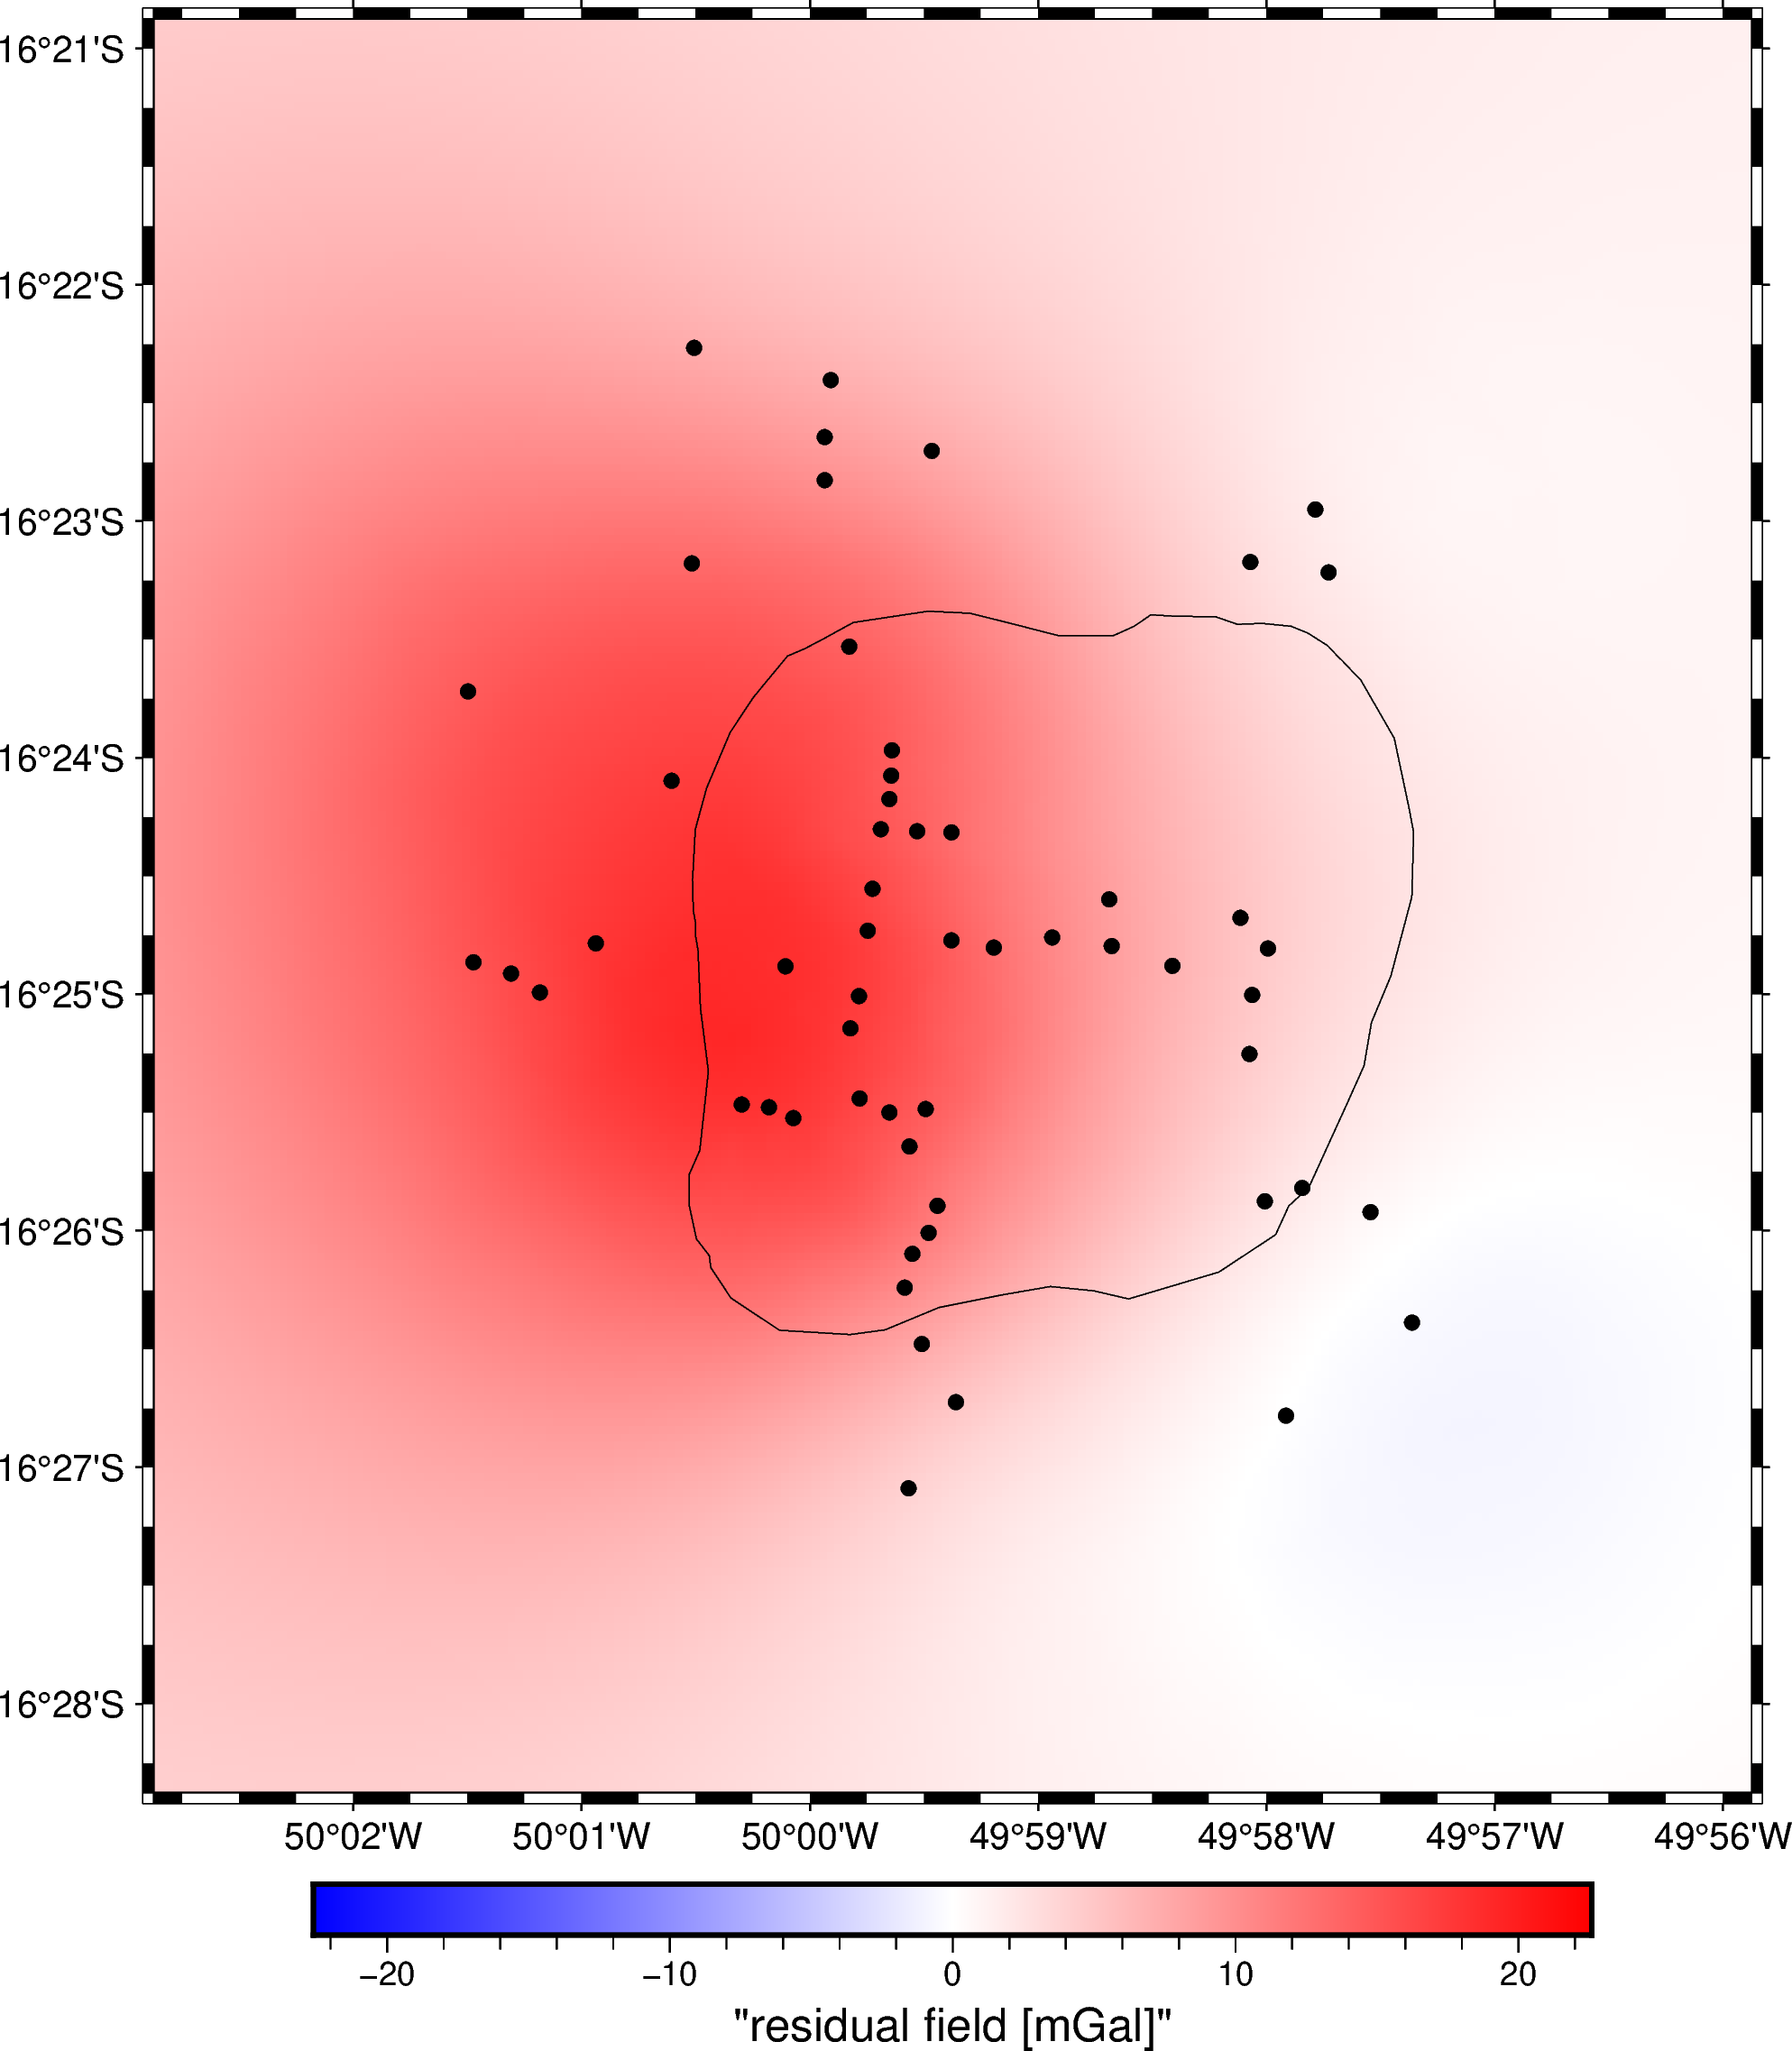

In [63]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.residual_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs], no_bg=True)
# pygmt.makecpt(cmap="polar+h", series=[-85, -40], no_bg=True)
fig.grdimage(
    residual_grid.gravity_residual,
    # shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
    region=region_cut
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.15c",
    fill="black",
)
fig.plot(data=pluton, projection='M')
 
fig.show()

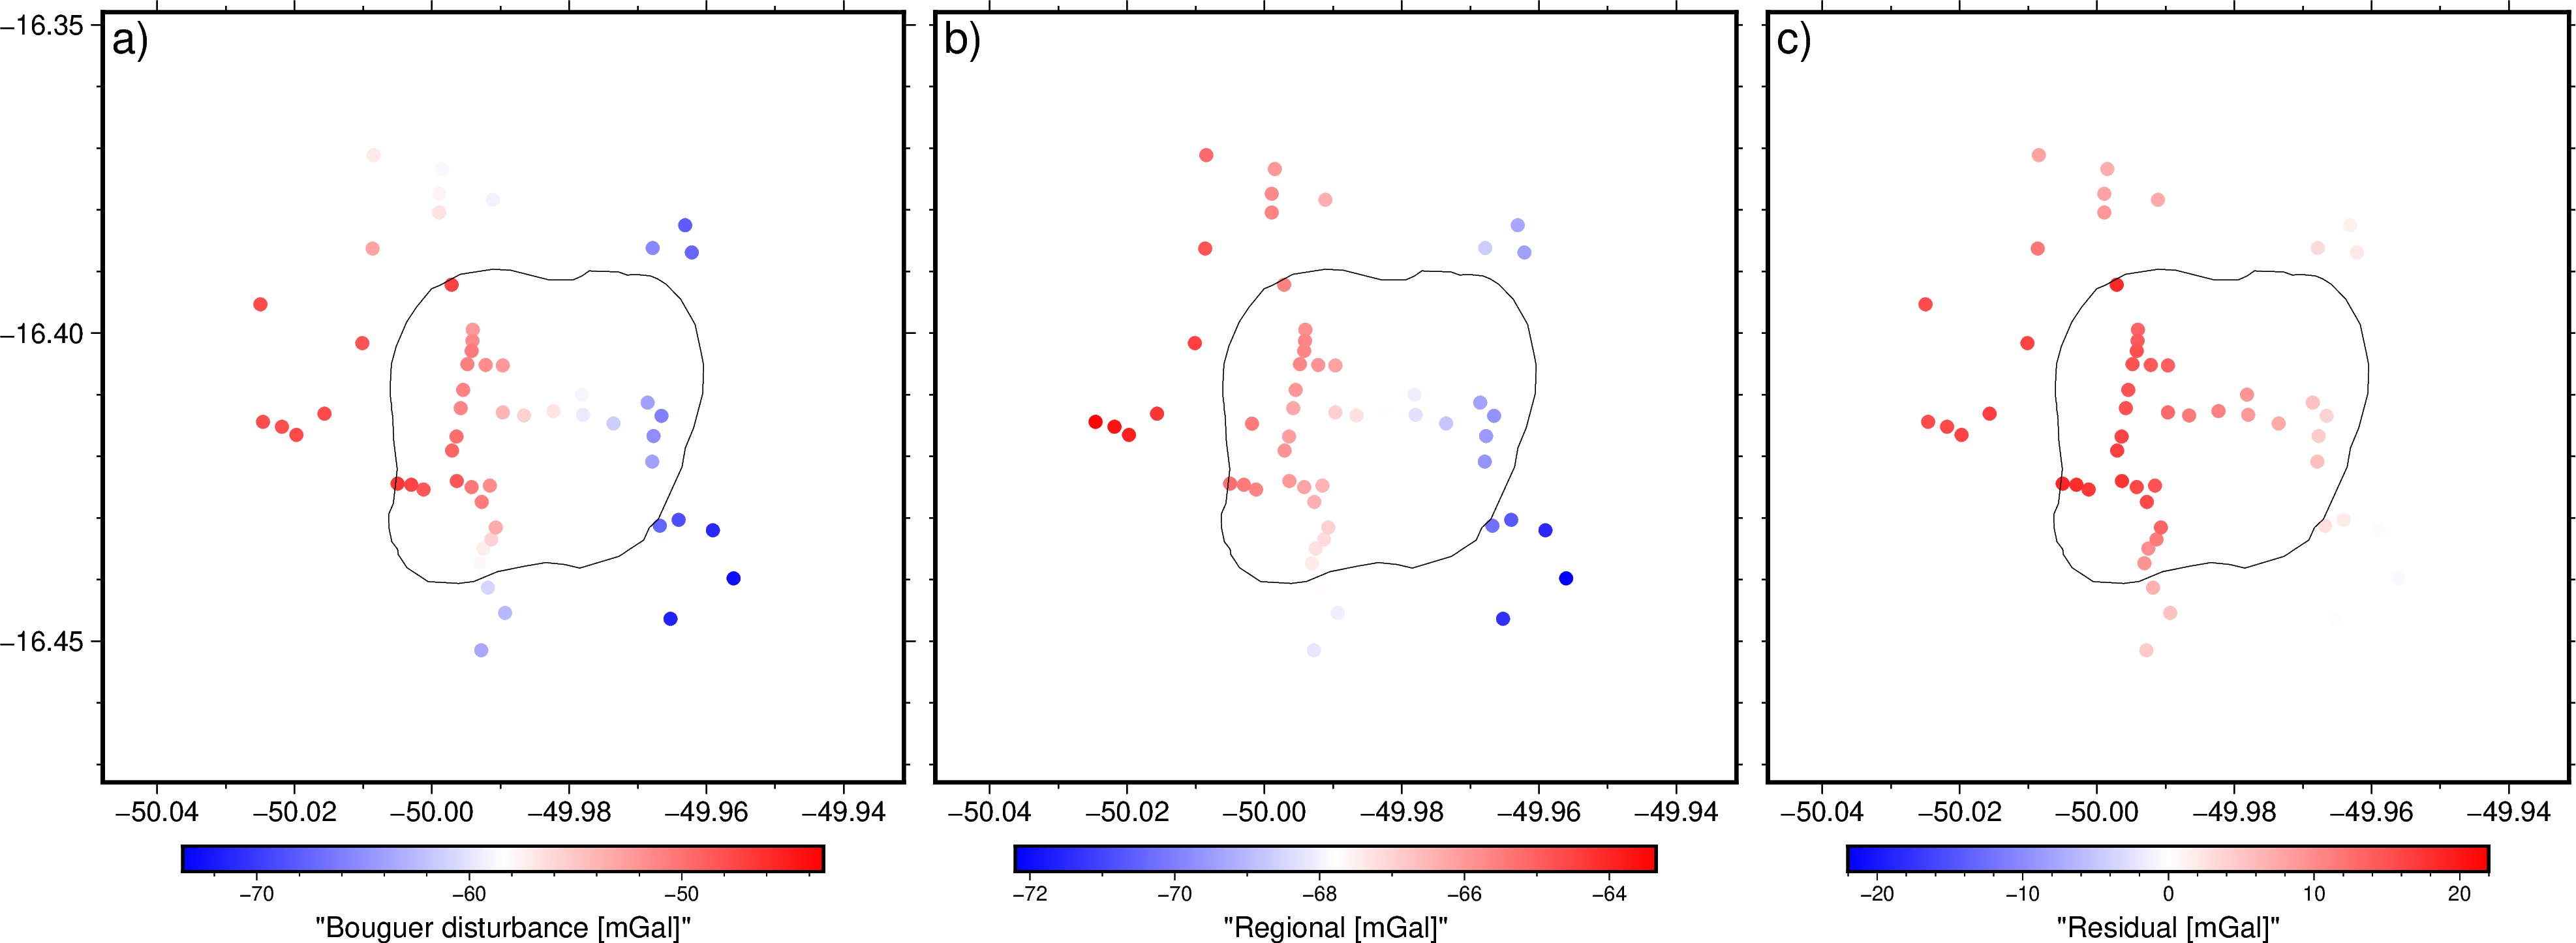

In [78]:
with plt.rc_context(mpl_rc):
    fig = pygmt.Figure()
    # fig.subplot(nrows=1, ncols=3, figsize=("15c", "5c"), frame="a")
    with fig.subplot(
        nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.05c"
    ):
        with fig.set_panel(panel=0):
            maxabs = vd.maxabs(data.gravity_bouguer_mgal)+0.01
            pygmt.makecpt(cmap="polar", series=[data.gravity_bouguer_mgal.min()*1.01, data.gravity_bouguer_mgal.max()*1.01])
            fig.plot(
                x=data.Longitude,
                y=data.Latitude,
                fill=data.gravity_bouguer_mgal,
                cmap=True,
                style="c5p",
                projection="X",
                frame=["WSne", "xaf", "yaf"],
            )
            fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
        with fig.set_panel(panel=1):
            maxabs = vd.maxabs(data.regional_bouguer)
            pygmt.makecpt(cmap="polar", series=[data.regional_bouguer.min(), data.regional_bouguer.max()])
            fig.plot(
                x=data.Longitude,
                y=data.Latitude,
                fill=data.regional_bouguer,
                cmap=True,
                style="c5p",
                projection="X",
                frame=["WSne", "xaf", "f"],
            )
            fig.colorbar(frame='af+l"Regional [mGal]"')
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
        with fig.set_panel(panel=2):
            maxabs = vd.maxabs(data.residual_mgal)
            pygmt.makecpt(cmap="polar", series=[-22, 22])
            # fig.grdimage(
            #     residual_grid.gravity_residual,
            #     # shading="+a45+nt0.15",
            #     projection="X",
            #     frame=["WSne", "xaf", "f"],
            #     region=region_cut
            # )
            fig.colorbar(frame='af+l"Residual [mGal]"')
            fig.plot(
                x=data.Longitude,
                y=data.Latitude,
                fill=data.residual_mgal,
                cmap=True,
                style="c5p",
                projection="X",
                frame=["WSne", "xaf", "f"],
            )
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")


fig.savefig(image_dir/'gravity_maps.png', dpi=300)
fig.show()
